In [640]:
library(ggplot2)
library(plyr)
library(dplyr)
library(ggpubr)
library(ggrepel)
library(Rtsne)
library(plotly)
library(limma)
library(HTqPCR)
library(readr)
library(tidyverse)
library(FactoMineR)
library(repr)


In [641]:
raw1 <- readCtData(files = "1362020244__YC8-YG2_CL_2021_081Y.csv", format = "BioMark", n.features = 96, n.data = 96)
raw2 <- readCtData(files = "1362020253_YC7-YA2_CL.csv", format = "BioMark", n.features = 96, n.data = 96) 
raw3 <- readCtData(files = "1362171187_NVA1-2-3.csv", format = "BioMark", n.features = 96, n.data = 96) 
raw4 <- readCtData(files = "1362419177_NVA4-HK_CL.csv", format = "BioMark", n.features = 96, n.data = 96) 
raw5 <- readCtData(files = "Biomark_2.csv", format = "BioMark", n.features = 96, n.data = 96)
raw6 <- readCtData(files = "1362020245_NVA1_EMT_2021.csv", format = "BioMark", n.features = 96, n.data = 96)
raw7 <- readCtData(files = "1361935069_NVA2_EMT_2021.csv", format = "BioMark", n.features = 96, n.data = 96)
raw8 <- readCtData(files = "1362020252_NVA1_TGFB_2021.csv", format = "BioMark", n.features = 96, n.data = 96)
raw9 <- readCtData(files = "1361935248_NVA2_TGFB_2021.csv", format = "BioMark", n.features = 96, n.data = 96)

In [642]:
head(raw1)

An object of class "qPCRset"
Size:  6 features, 96 samples
Feature types:		  
Feature names:		 Acta2 Aicda Alb ...
Feature classes:		  
Feature categories:	 OK 
Sample names:		 1 2 3 ...

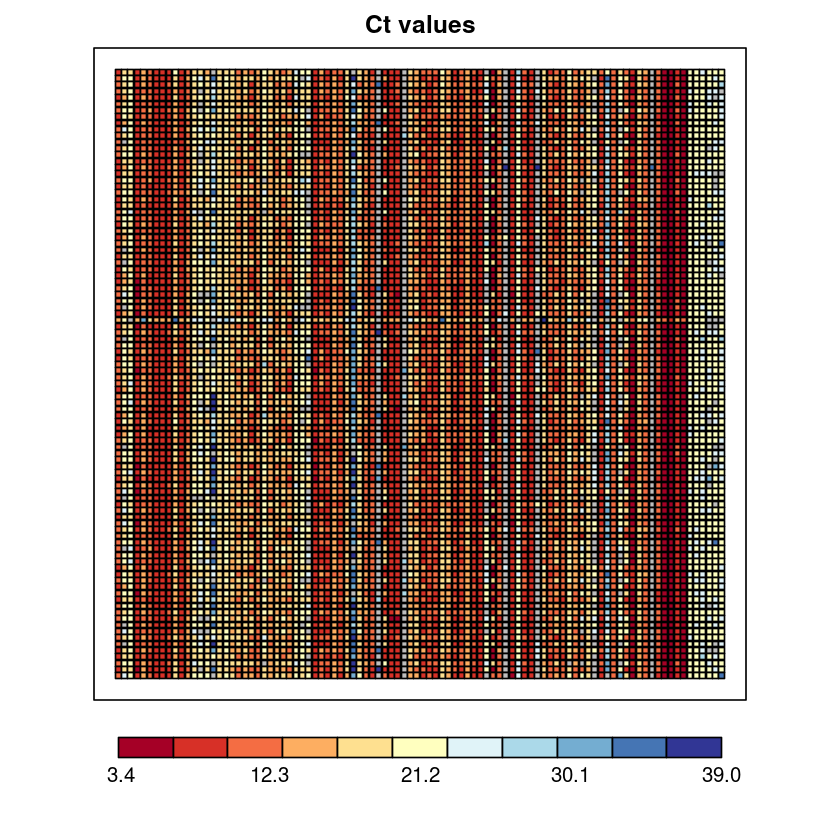

In [643]:
plotCtArray(raw1,col = brewer.pal(11, "RdYlBu"))

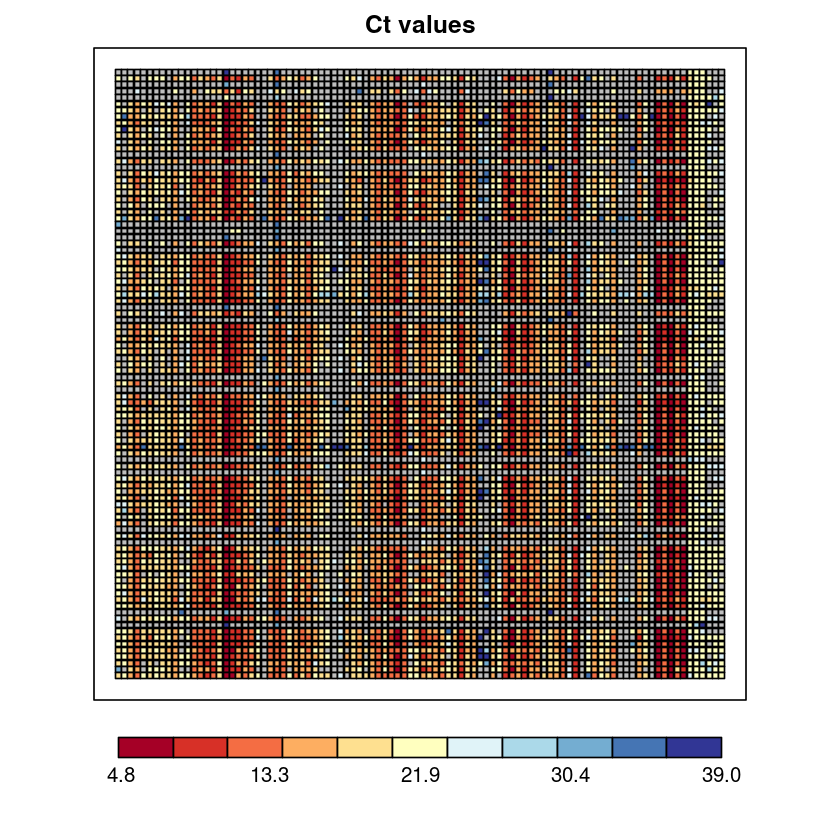

In [644]:
plotCtArray(raw2,col = brewer.pal(11, "RdYlBu"))

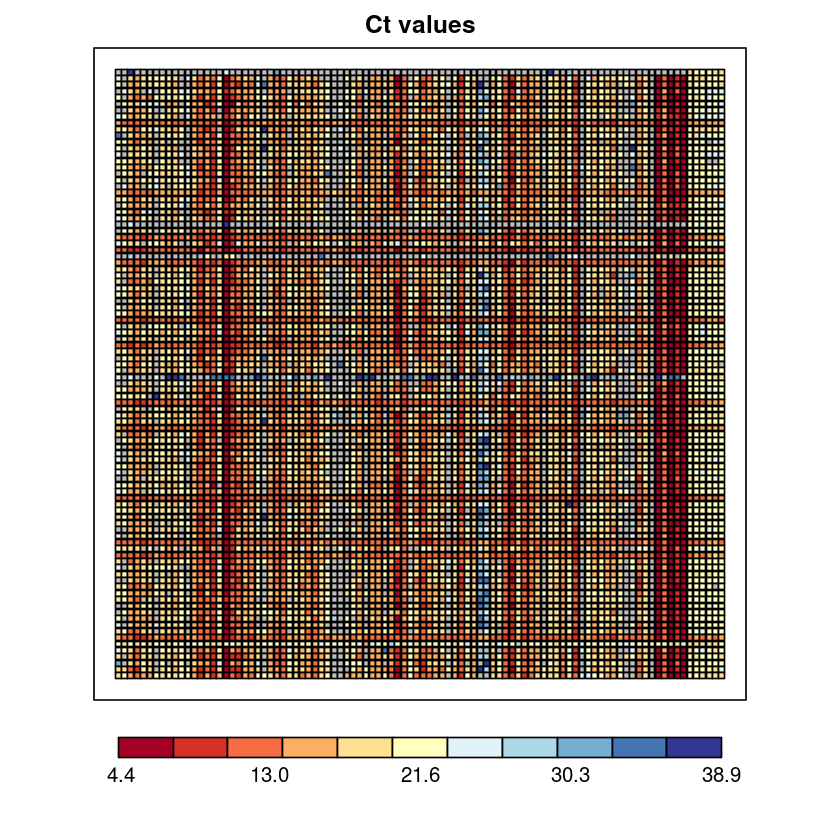

In [645]:
plotCtArray(raw3,col = brewer.pal(11, "RdYlBu"))

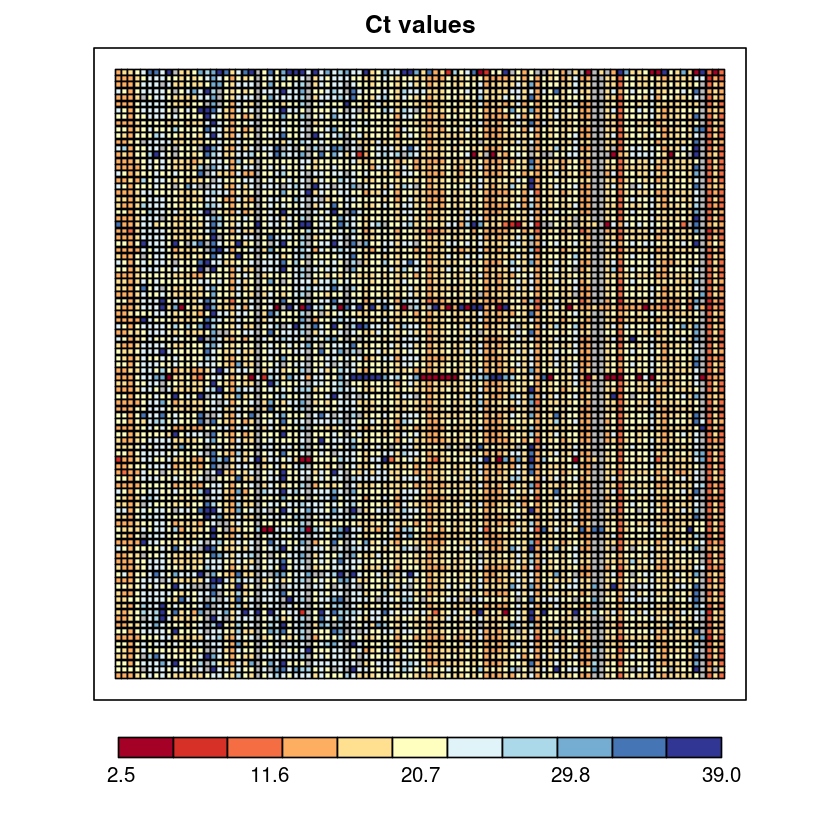

In [646]:
plotCtArray(raw4,col = brewer.pal(11, "RdYlBu"))

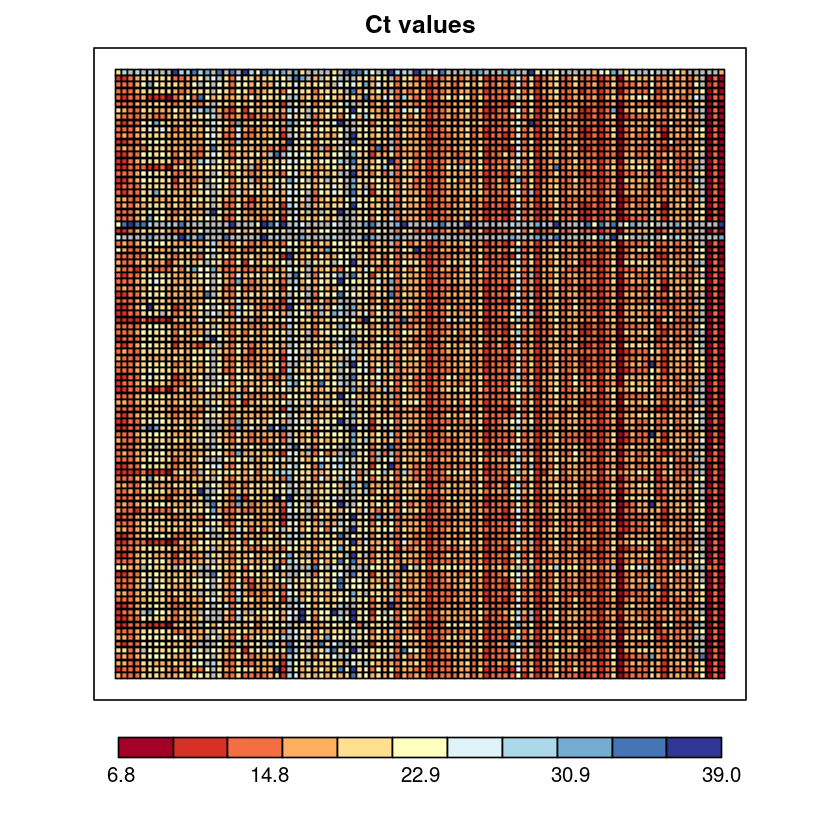

In [647]:
plotCtArray(raw5, col = brewer.pal(11, "RdYlBu"))

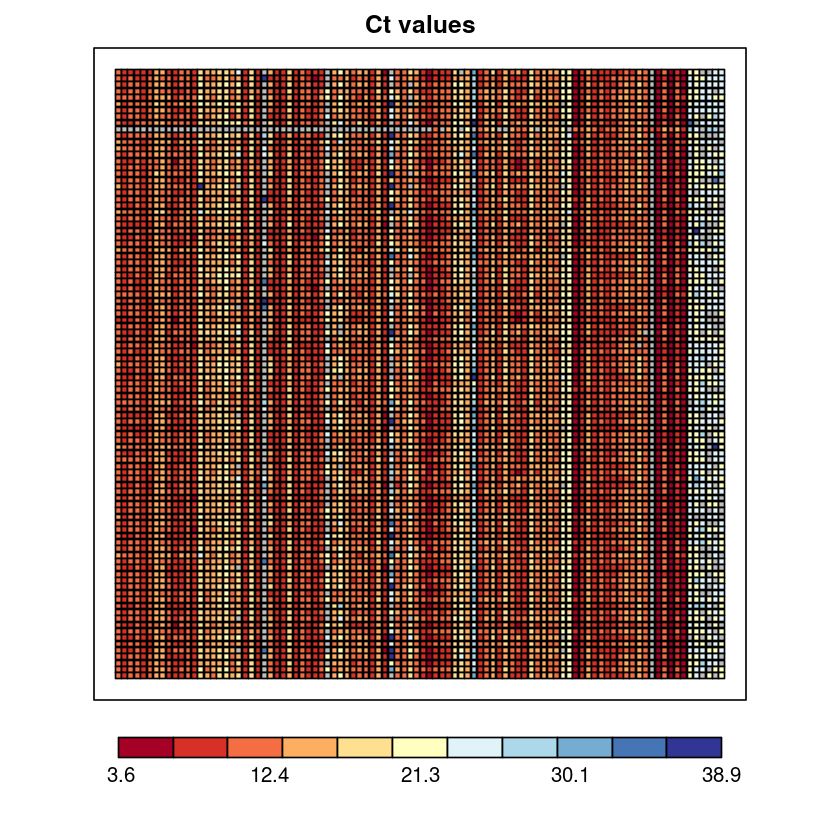

In [648]:
plotCtArray(raw6, col = brewer.pal(11, "RdYlBu"))

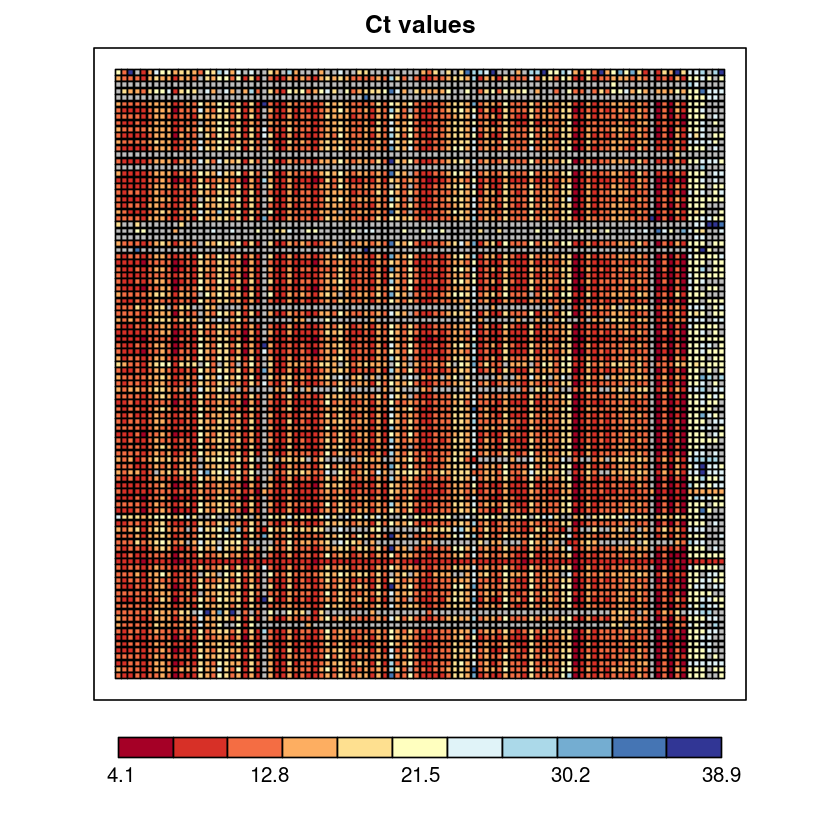

In [649]:
plotCtArray(raw7, col = brewer.pal(11, "RdYlBu"))

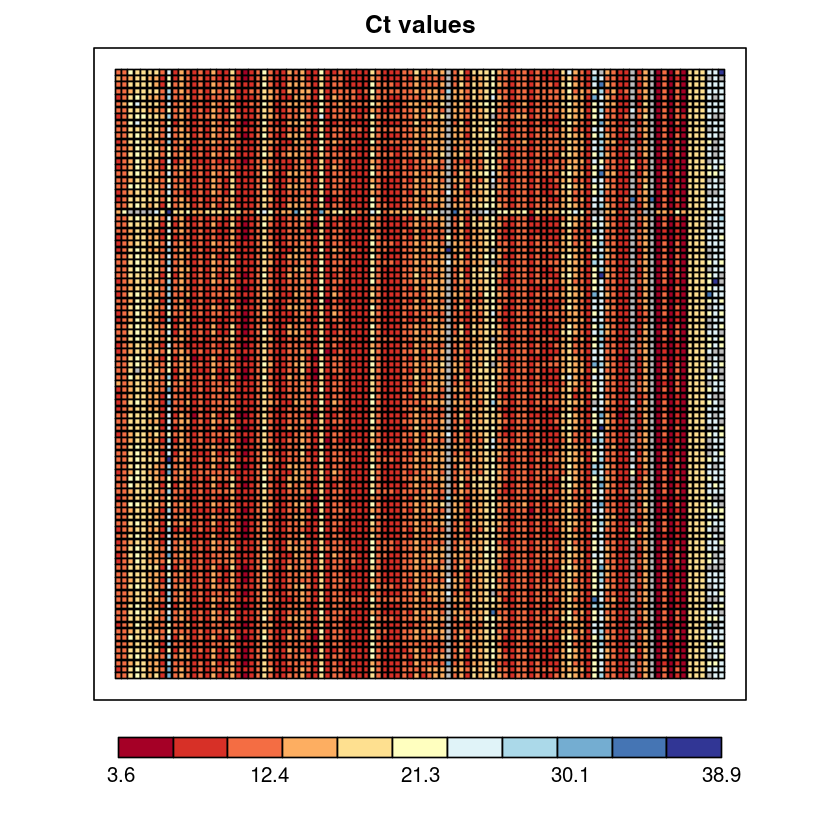

In [650]:
plotCtArray(raw8, col = brewer.pal(11, "RdYlBu"))

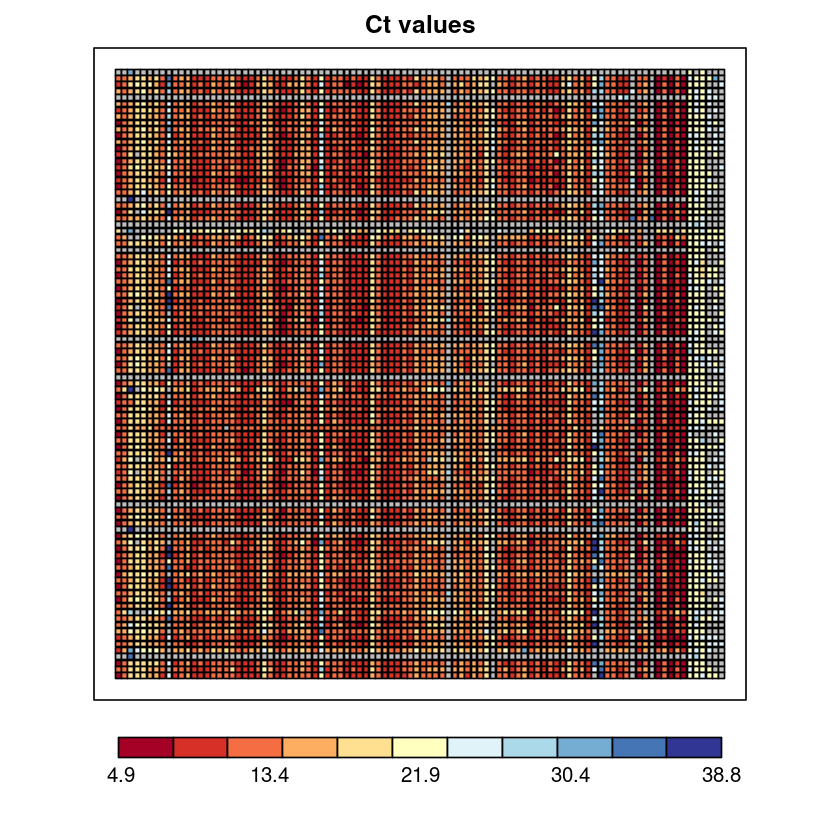

In [651]:
plotCtArray(raw9, col = brewer.pal(11, "RdYlBu"))

In [652]:
# create a function to process the raw data and turned them into dCt
sanitize_biomark <- function (biomark_csv_file) {
  path_to_qPCR_data <- biomark_csv_file
  
  biomark_raw <- read_csv(file=path_to_qPCR_data, col_names = TRUE, skip = 11)
  biomark_named <- biomark_raw %>% rename( Gene = Name_1 ) %>% select(ID, Name, Gene, Value, Call, Threshold)
  
  
  # Filtered out Failed calls and high Ct values
  biomark_filtered <- biomark_named %>% filter( Call != "Fail" & 
                                                Value < 28 & 
                                               !grepl("H2O",Name) & 
                                               !grepl("H20",Name) & 
                                               !grepl("EMP",Name) & 
                                               !grepl("water",Name))
  
  
  # Filter out genes and samples with less than 30 good Ct values
  
  biomark_filtered <- biomark_filtered %>% filter(!(Gene %in% (biomark_filtered %>% count(Gene) %>% filter (n < 0) %>% .$Gene)))
  
  biomark_filtered <- biomark_filtered %>% filter(!(Name %in% (biomark_filtered %>% count(Name) %>% filter (n < 30) %>% .$Name)))
  
  # Calculate the housekeeping gene control using the mean of Gadph, Tbp, bActin, B2m and Gapdh
  
  biomark_hk <- biomark_filtered %>% filter( Gene %in% c("Gapdh", "Actb","B2m", "Gusb","Hsp90ab1" ,"bActin", "B2M", "Rpl13A", "Hprt1")) %>% group_by(Name) %>% summarise( hk_mean = (mean(Value)))
  head(biomark_hk)
  biomark_dCt <- inner_join(biomark_filtered, biomark_hk, by = c("Name" = "Name")) %>% mutate(dCt = (-1*(Value-hk_mean)))
  biomark_dCt <- biomark_dCt %>% filter(!(Gene %in% c("PPC", "RTC", "MGDC" )))
  
  # Spread the data into a matrix
  biomark_spread <- biomark_dCt%>% select(Name, Gene, dCt) %>% spread(key = Gene, value= dCt) %>% replace(.,is.na(.), -15) 
  
  # Remove the three housekeeping genes
  biomark_spread_nohk <- biomark_spread %>% select(-one_of(c("Gapdh", "Actb","B2m", "Gusb", "Hsp90ab1" ,"bActin", "B2M", "Rpl13A", "Hprt1")))
  
}

In [653]:
biomark_NVA1 <- sanitize_biomark("1362020244__YC8-YG2_CL_2021_081Y.csv")
biomark_NVA2 <- sanitize_biomark("1362020253_YC7-YA2_CL.csv")
biomark_NVA3 <- sanitize_biomark("1362171187_NVA1-2-3.csv")
biomark_NVA4 <- sanitize_biomark("1362419177_NVA4-HK_CL.csv")
biomark_NVA5 <- sanitize_biomark("Biomark_2.csv")
biomark_NVA5 <- biomark_NVA5[77:93,]
biomark_NVA1_EMT <- sanitize_biomark("1362020245_NVA1_EMT_2021.csv")
biomark_NVA2_EMT <- sanitize_biomark("1361935069_NVA2_EMT_2021.csv")
biomark_NVA1_TGF <- sanitize_biomark("1362020252_NVA1_TGFB_2021.csv")
biomark_NVA2_TGF <- sanitize_biomark("1361935248_NVA2_TGFB_2021.csv")

Warning message:
“Duplicated column names deduplicated: 'Name' => 'Name_1' [5], 'Type' => 'Type_1' [6]”

── Column specification ─────────────────────────────────
cols(
  ID = col_character(),
  Name = col_character(),
  Type = col_character(),
  rConc = col_double(),
  Name_1 = col_character(),
  Type_1 = col_character(),
  Value = col_double(),
  Quality = col_double(),
  Call = col_character(),
  Threshold = col_double()
)


Warning message:
“Unknown columns: `bActin`, `B2M`, `Rpl13A`, `Hprt1`”
Warning message:
“Duplicated column names deduplicated: 'Name' => 'Name_1' [5], 'Type' => 'Type_1' [6]”

── Column specification ─────────────────────────────────
cols(
  ID = col_character(),
  Name = col_character(),
  Type = col_character(),
  rConc = col_double(),
  Name_1 = col_character(),
  Type_1 = col_character(),
  Value = col_double(),
  Quality = col_double(),
  Call = col_character(),
  Threshold = col_double()
)


Warning message:
“Unknown columns: `bActin`, `B2M`, `Rpl13A`, `Hp

In [654]:
head(biomark_NVA1)

Name,Acta2,Aicda,Alb,Alpl,Ccna2,Cd44,Cdc42,Cdk1,Chd1,⋯,Tcl1,Tdgf1,Tek,Tert,Thap11,Thy1,Trim28,Utf1,Zfp42,Zfx
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
LMS3AC025D2A,-6.477598,-10.80490,-13.87625,-0.2441128,-4.571095,-3.910778,-1.947708,-1.452311,-2.572132,⋯,-15.97900,-10.222134,-4.026479,-5.346654,-6.009061,-10.792697,0.5904392,-3.265970,-13.87509,-5.225458
LMS3AC025D2B,-6.456830,-10.70803,-14.30774,-0.1799197,-6.114599,-4.033550,-1.634049,-1.382010,-2.539544,⋯,-14.72122,-10.374431,-3.664121,-5.522339,-5.738032,-9.755341,0.3167592,-3.340774,-13.78454,-4.912786
LMS3AC025D2C,-6.723373,-10.55486,-14.77774,-0.5869412,-6.372175,-4.225009,-1.077657,-1.168919,-2.598655,⋯,-16.97833,-10.717663,-3.438707,-5.793280,-5.541819,-9.259588,0.4597039,-3.275004,-13.75803,-5.068118
LMS3AC025D4A,-3.005000,-10.38698,-12.98461,-0.4045167,-6.151631,-3.564682,-1.455084,-1.442746,-2.344201,⋯,-17.09266,-9.634164,-4.745064,-5.476175,-5.413894,-8.922539,0.5042802,-2.474658,-13.86808,-4.949094
LMS3AC025D4B,-3.159650,-11.34036,-13.64117,-0.7902054,-6.035592,-3.849626,-1.796334,-1.985153,-3.094028,⋯,-16.36250,-9.509382,-5.209423,-6.172530,-5.789073,-9.767686,0.3555127,-3.367262,-17.86430,-4.962356
LMS3AC025D4C,-3.604168,-11.13407,-13.97276,-0.9735898,-5.342098,-3.843295,-2.128980,-2.207225,-3.096328,⋯,-15.00000,-9.252347,-5.047658,-5.928266,-5.778693,-9.388494,0.3019846,-3.492363,-14.40239,-5.146916


In [655]:
head(biomark_NVA2)

Name,Alb,Apoh,Aqp1,Bmp4,Ccr5,Cd34,Cd3e,Cd79a,Chat,⋯,Slc32a1,Smtn,Sox17,Sox2,Sox7,T,Tat,Tyr,Zfp42,Zic1
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
CAV2AC025D2A,-13.929419,-15.0000,-10.154210,-15.00000,-5.961611,-12.718375,-15.000000,-11.574841,-13.429234,⋯,-7.126698,-14.61622,-13.38133,0.36095332,-12.77636,-2.049060,-15.00000,-15,-15.00000,-8.260323
CAV2AC025D2B,-12.846441,-15.0000,-8.833229,-15.00000,-6.332856,-11.213959,-15.401889,-10.897416,-12.862720,⋯,-7.107802,-15.00000,-11.97831,-0.06686479,-12.35521,-2.877294,-15.00000,-15,-12.55147,-8.680345
CAV2AC025D2C,-12.703947,-15.0000,-8.660316,-14.07248,-6.308022,-10.424180,-14.832781,-10.882344,-10.639257,⋯,-7.069234,-15.00000,-16.72026,-0.21036508,-11.88480,-2.764895,-12.80928,-15,-15.00000,-9.063801
CAV2AC025D4A,-6.818942,-10.9916,-6.840831,-15.00000,-2.591296,-9.225023,-9.860924,-8.836136,-9.961744,⋯,-5.171879,-15.00000,-12.24569,0.52118767,-15.00000,-3.965100,-15.00000,-15,-15.00000,-3.778173
CAV2AC025D4B,-9.780633,-15.0000,-6.808857,-15.00000,-3.352143,-10.591822,-13.924175,-10.718802,-10.763907,⋯,-6.433067,-15.00000,-13.87352,-1.08224630,-10.62252,-4.519371,-15.00000,-15,-15.00000,-5.750315
CAV2AC025D4C,-10.139263,-15.0000,-7.523660,-14.16451,-3.830653,-10.430717,-13.493820,-9.283435,-10.624935,⋯,-6.414148,-15.00000,-13.10695,-1.03754602,-11.28862,-4.395879,-15.00000,-15,-14.35768,-5.991447


In [656]:
head(biomark_NVA3)

Name,Alb,Apoh,Aqp1,Bmp4,Ccr5,Cd34,Cd3e,Cd79a,Chat,⋯,Slc32a1,Smtn,Sox17,Sox2,Sox7,T,Tat,Tyr,Zfp42,Zic1
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
CAV2AC100D2D,-13.896660,-13.64606,-10.024301,-6.380569,-10.12078,-14.310138,-15.00000,-12.467730,-11.30003,⋯,-7.247204,-12.91489,-15,-2.862648,-11.566922,-7.878376,-15,-15.00000,-15.00000,-10.304787
CAV2AC100D2E,-15.019623,-15.00000,-10.827233,-7.363502,-10.52040,-13.917983,-13.37324,-13.538818,-13.79224,⋯,-7.482510,-17.41240,-15,-2.480502,-11.455171,-7.605523,-15,-13.79338,-12.07488,-10.051207
CAV2AC100D4A,-9.825270,-11.97966,-7.517926,-3.827841,-15.00000,-9.792271,-15.00000,-10.696941,-12.12225,⋯,-8.376526,-13.26325,-15,-2.632826,-9.480265,-5.633940,-15,-15.00000,-11.57199,-9.275364
CAV2AC100D4B,-9.869925,-12.35547,-5.987810,-2.788623,-12.83426,-10.614726,-15.00000,-9.668846,-12.51812,⋯,-8.450429,-14.82772,-15,-2.497912,-10.405344,-5.634767,-15,-15.00000,-12.73745,-8.695519
CAV2AC100D4C,-10.826578,-11.65686,-5.668746,-3.305571,-12.46356,-10.355402,-15.00000,-9.905465,-12.42087,⋯,-8.162049,-13.04065,-15,-2.639399,-9.184451,-5.356619,-15,-15.00000,-15.00000,-9.122446
CAV2AC100D4D,-15.000000,-15.00000,-10.580135,-7.057494,-13.55307,-12.162611,-15.00000,-9.761731,-11.48916,⋯,-8.552177,-13.47071,-15,-2.758257,-11.384122,-6.625723,-15,-15.00000,-11.23496,-11.060356


In [657]:
head(biomark_NVA4)

Name,Acvr1,Acvr2,Axin2,Bmp2,Bmp4,Bmpr1a,Bmpr1b,Cdc42,Cdh1,⋯,Tgfbr2,Thy1,Twist1,Vim,Wnt11,Wnt3,Wnt3a,Wnt5a,Zfp42,Zic1
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
FS09AC100D1A,-8.047635,-5.466908,-5.252431,-8.970626,-8.610463,-3.880671,-15.000000,-2.003215,-5.316996,⋯,-9.616727,-7.832940,-7.548131,0.02804561,-8.381068,-4.735817,-11.666082,-11.427247,-13.278503,-9.145212
FS09AC100D1B,-8.124824,-4.128133,-3.668131,-12.343638,-9.841501,-3.435122,-9.982412,-1.662324,-9.242922,⋯,-10.045333,-10.520544,-9.119020,-0.88736292,-10.385905,-5.173640,-8.797217,-12.044410,-14.790580,-6.055286
FS09AC100D1C,-6.767786,-4.268709,-3.626705,-9.383836,-9.652584,-3.274913,-11.310626,-1.728957,-7.418323,⋯,-9.837450,-8.707233,-8.006842,0.13365095,-7.897569,-4.147540,-7.823813,-11.087571,-11.534256,-6.131061
FS09AC100D2A,-7.273403,-4.113074,-4.393609,-8.966985,-11.358024,-3.247771,-15.000000,-1.665782,-7.542917,⋯,-9.626413,-9.051868,-8.226870,-0.19021359,-7.718373,-5.042554,-10.055242,-9.725474,-9.782931,-5.860447
FS09AC100D2B,-6.833417,-3.844111,-3.645294,-11.232134,-9.414661,-3.334055,-12.088272,-1.252989,-7.250147,⋯,-10.814523,-11.000267,-9.342363,-0.61289318,-9.979785,-5.029816,-9.806425,-11.639969,-11.142726,-4.902722
FS09AC100D2C,-7.287710,-4.649117,-4.563544,-9.234566,-8.696048,-3.535151,-10.837537,-1.584293,-8.691471,⋯,-10.432160,-8.851122,-7.777898,-0.28441586,-8.201642,-4.608086,-10.786721,-10.677736,-8.837982,-6.382842


In [658]:
head(biomark_NVA5)

Name,Acvr1,Acvr2,Axin2,Bmp2,Bmp4,Bmpr1a,Bmpr1b,Cdc42,Cdh1,⋯,Tgfbr2,Thy1,Twist1,Vim,Wnt11,Wnt3,Wnt3a,Wnt5a,Zfp42,Zic1
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
FS CONT,-9.177706,-5.034365,-5.060369,-15.09007,-11.37289,-3.037347,-11.168850,-1.598007,-9.926582,⋯,-11.115383,-8.841664,-10.935080,-1.0730690,-13.336988,-7.404011,-9.625004,-15.00000,-15.08881,-9.523900
FS d2 ACT,-7.566436,-5.850827,-6.345715,-12.65987,-10.93932,-3.534423,-11.343479,-2.121479,-7.022047,⋯,-11.946084,-7.855629,-10.297963,-0.7265261,-9.992726,-7.184723,-10.630898,-15.00000,-13.73723,-15.000000
FS d2 NOD,-8.958603,-5.950618,-5.544605,-14.32499,-12.09869,-3.523710,-11.983955,-2.093688,-8.475195,⋯,-11.919764,-7.180936,-11.285200,-1.8059696,-13.026564,-7.646590,-9.667196,-19.71405,-15.48188,-11.398573
FS d2 SB43,-8.526541,-5.657177,-5.222754,-11.52760,-9.77971,-3.248824,-13.047823,-1.520752,-8.928894,⋯,-9.925553,-10.828938,-8.947196,-1.4899903,-13.784224,-8.120072,-9.955623,-15.00000,-11.56748,-10.548971
FS d4 ACT,-7.988766,-6.042383,-6.504941,-11.88738,-8.90173,-4.059530,-12.170751,-2.154307,-7.216266,⋯,-12.417814,-7.509195,-9.786065,-2.1969226,-9.732007,-9.279666,-10.930237,-15.00000,-11.17687,-14.474670
FS d4 NOD,-8.997432,-4.407745,-5.427494,-15.73224,-10.48132,-3.448989,-9.924959,-2.395238,-10.093205,⋯,-13.016716,-11.421455,-10.427989,-0.3800423,-12.838024,-6.762840,-11.907105,-17.80771,-12.23567,-7.226317


In [659]:
head(biomark_NVA1_TGF)

Name,Acta2,Acvr1,Acvrl1,Agt,Aipl1,Ar,Atf3,Atf4,Bach1,⋯,Sox4,Sp1,Srebf2,Tgfb2,Tgfbr2,Thbs1,Tnfsf10,Txnip,Vegfa,Wfs1
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
LMS3AC025D2A,-6.859626,-4.816927,-8.997225,-11.42025,-11.72724,-8.847420,-9.631519,-2.643435,-15.94178,⋯,-19.70988,-1.838674,-4.819786,-6.225172,-7.262792,-4.166829,-15,-1.936357,-1.576813,-4.813013
LMS3AC025D2B,-6.671871,-4.732301,-9.035226,-12.06158,-11.40952,-9.225957,-9.707335,-3.295010,-16.94011,⋯,-20.55826,-1.822166,-5.551465,-6.441209,-7.417301,-3.826078,-15,-1.567968,-1.422797,-4.582913
LMS3AC025D2C,-6.677825,-5.088850,-9.240318,-12.41896,-12.48242,-9.209913,-9.823494,-3.811758,-15.57687,⋯,-15.69356,-1.591397,-5.807017,-6.766989,-7.780562,-3.758210,-15,-1.755257,-1.142578,-4.387745
LMS3AC025D4A,-4.144531,-4.263530,-9.822584,-11.75926,-11.95422,-8.995522,-10.063957,-3.433211,-15.00000,⋯,-17.06822,-1.981301,-5.831899,-5.918210,-7.885951,-4.587669,-15,-1.892733,-1.354670,-4.620768
LMS3AC025D4B,-4.558746,-4.708766,-9.492391,-11.09159,-11.94484,-9.692316,-9.800251,-2.806357,-21.10071,⋯,-16.42556,-2.568197,-4.813274,-5.749915,-7.414587,-5.022381,-15,-2.534367,-1.805104,-5.152509
LMS3AC025D4C,-4.315447,-4.280420,-9.147494,-11.33040,-11.20614,-9.052293,-9.454242,-2.523014,-20.09029,⋯,-16.20895,-2.281554,-5.157844,-5.845682,-7.684098,-4.878541,-15,-2.266565,-1.364993,-5.123107


In [660]:
head(biomark_NVA2_TGF)

Name,Acta2,Acvr1,Acvrl1,Agt,Aipl1,Ar,Atf3,Atf4,Bach1,⋯,Sox4,Sp1,Srebf2,Tgfb2,Tgfbr2,Thbs1,Tnfsf10,Txnip,Vegfa,Wfs1
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
CAV2AC025D2A,-5.6254543,-4.464067,-7.909332,-9.934951,-11.23883,-7.968267,-9.010326,-3.594008,-17.04848,⋯,-15.00000,-1.215275,-6.804211,-5.632932,-6.435658,-3.688717,-15,-0.6772616,-2.470586,-4.566022
CAV2AC025D2B,-6.4000444,-5.003057,-7.961440,-9.569158,-11.81288,-8.167177,-9.012460,-3.053908,-15.00000,⋯,-14.31684,-1.818085,-5.513731,-5.720679,-5.876602,-3.946459,-15,-1.4242311,-2.596446,-5.020951
CAV2AC025D2C,-5.9422214,-4.873161,-7.510396,-9.445322,-11.70407,-7.981434,-8.820736,-3.556969,-18.27931,⋯,-13.60304,-1.414834,-5.933383,-5.601939,-5.846215,-3.859323,-15,-0.8409406,-2.356830,-4.585226
CAV2AC025D4A,1.6193861,-4.100147,-10.552462,-12.937137,-11.15963,-8.512644,-8.067529,-3.581877,-15.00000,⋯,-15.00000,-1.636508,-6.248265,-5.217934,-5.430044,1.449333,-15,-2.1658699,-2.616981,-4.483962
CAV2AC025D4B,1.1952537,-4.255456,-10.639058,-9.491864,-10.49052,-8.530084,-8.057825,-2.752726,-15.00000,⋯,-15.61794,-2.207282,-4.095959,-4.809457,-4.169508,1.380870,-15,-2.9485875,-3.453066,-4.827501
CAV2AC025D4C,0.9320767,-4.204932,-10.646463,-11.423384,-10.92012,-8.367942,-7.538649,-2.641044,-15.67595,⋯,-15.00000,-1.775540,-4.751014,-5.232988,-5.118093,1.163560,-15,-3.1250772,-3.267873,-4.817054


In [661]:
head(biomark_NVA1_EMT)

Name,Ahnak,Akt1,Bmp1,Bmp7,Cald1,Camk2N1,Cav2,Cdh1,Cdh2,⋯,Tspan13,Twist1,Vcan,Vim,Vps13A,Wnt11,Wnt5A,Wnt5B,Zeb1,Zeb2
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
LMS3AC025D2A,-5.694603,-2.768944,-4.129917,-3.485458,-2.966433,-4.113699,-8.283455,-5.751065,-4.303068,⋯,-1.370264,-7.021128,-1.421987,0.31800487,-3.927741,-5.198931,-4.183413,-6.615921,-4.233357,-4.104752
LMS3AC025D2B,-5.803653,-3.227547,-4.478319,-3.869003,-3.225024,-4.484186,-8.478946,-6.108581,-4.406971,⋯,-1.649267,-7.194782,-1.710336,0.19280242,-4.114955,-5.284418,-4.401338,-6.743769,-4.253575,-4.097579
LMS3AC025D2C,-6.275178,-3.385477,-4.605045,-4.089168,-3.411936,-4.886756,-8.811352,-6.296486,-4.450685,⋯,-1.777214,-7.262216,-2.035133,0.03866094,-4.410062,-5.253069,-4.603955,-6.707081,-4.541058,-4.485405
LMS3AC025D4A,-6.453225,-3.030392,-4.271172,-4.718965,-2.708883,-4.284388,-9.403684,-6.725912,-5.195174,⋯,-1.993391,-5.902333,-1.840605,0.17092567,-4.603107,-7.922606,-4.781595,-7.064323,-4.076120,-3.795271
LMS3AC025D4B,-6.421522,-3.063389,-4.495438,-5.064475,-3.002184,-4.229858,-9.365832,-6.959421,-4.899083,⋯,-2.124207,-6.026787,-2.227660,-0.07431135,-4.855874,-7.816765,-4.873737,-7.105464,-3.943171,-3.702910
LMS3AC025D4C,-6.050440,-2.875115,-3.980189,-4.639676,-2.359135,-3.661438,-8.821976,-6.790863,-4.590262,⋯,-1.910410,-5.896057,-1.743872,-0.03196923,-4.505916,-7.928473,-4.777316,-7.146101,-3.989634,-3.664431


In [662]:
head(biomark_NVA2_EMT)

Name,Ahnak,Akt1,Bmp1,Bmp7,Cald1,Camk2N1,Cav2,Cdh1,Cdh2,⋯,Tspan13,Twist1,Vcan,Vim,Vps13A,Wnt11,Wnt5A,Wnt5B,Zeb1,Zeb2
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
CAV2AC025D2A,-5.424899,-1.6021242,-2.655782,-1.844770,-0.8170911,-4.326511,-7.070224,-5.705692,-5.251437,⋯,-0.9323861,-6.836259,0.0928447,1.5548659,-3.612204,-4.986231,-3.211583,-6.281965,-5.465426,-4.531690
CAV2AC025D2B,-4.974827,-1.6880068,-3.137319,-2.797585,-1.3023168,-4.767461,-6.776628,-5.799107,-5.037540,⋯,-1.4105461,-6.620521,-0.4078476,0.9994828,-3.541859,-6.128435,-3.247017,-6.288096,-4.705106,-4.094247
CAV2AC025D2C,-4.738343,-2.5400961,-3.473805,-3.317664,-1.5562014,-5.218051,-7.105356,-5.737169,-5.135032,⋯,-1.5560943,-6.420535,-0.3750244,0.8357055,-3.398556,-5.809596,-3.312497,-6.584521,-4.760035,-3.974118
CAV2AC025D4A,-2.754552,-0.5424380,-1.316830,-2.363181,1.4466802,-2.475285,-5.427097,-7.628750,-4.778690,⋯,-0.6461326,-4.552553,0.2934478,2.5384081,-3.598721,-4.078705,-1.916834,-5.471394,-4.992153,-4.001746
CAV2AC025D4B,-2.301660,-0.8063702,-1.708894,-3.347666,0.8521639,-3.560025,-5.246040,-7.687923,-4.748893,⋯,-1.6486664,-4.906366,-0.3515939,1.7685209,-4.193390,-4.498024,-2.575043,-5.635671,-5.249787,-4.090763
CAV2AC025D4C,-2.576332,-1.2153357,-2.423634,-3.868255,0.3659698,-3.581813,-6.174507,-7.910444,-4.263215,⋯,-1.5646681,-4.996843,-0.5332288,1.8534743,-4.459786,-4.233609,-3.371452,-5.943382,-4.976114,-3.718951


In [663]:
# Match the names of NVA5
biomark_NVA5$Name[(which(biomark_NVA5$Name == "FS CONT"))] <- "FS09CT000D0D"
biomark_NVA5$Name[(which(biomark_NVA5$Name == "FS d2 ACT"))] <- "FS09AC100D2D"
biomark_NVA5$Name[(which(biomark_NVA5$Name == "FS d2 NOD"))] <- "FS09NO100D2D"
biomark_NVA5$Name[(which(biomark_NVA5$Name == "FS d2 SB43"))] <- "FS09SB001D2D"
biomark_NVA5$Name[(which(biomark_NVA5$Name == "FS d4 ACT"))] <- "FS09AC100D4D"
biomark_NVA5$Name[(which(biomark_NVA5$Name == "FS d4 NOD"))] <- "FS09NO100D4D"
biomark_NVA5$Name[(which(biomark_NVA5$Name == "FS d4 SB43"))] <- "FS09SB001D4D"

biomark_NVA5$Name[(which(biomark_NVA5$Name == "FX CONT"))] <- "FS9#CT000D0D"
biomark_NVA5$Name[(which(biomark_NVA5$Name == "FX d2 ACT"))] <- "FS9#AC100D2D"
biomark_NVA5$Name[(which(biomark_NVA5$Name == "FX d2 NOD"))] <- "FS9#NO100D2D"
biomark_NVA5$Name[(which(biomark_NVA5$Name == "FX d2 SB43"))] <- "FS9#SB001D2D"
biomark_NVA5$Name[(which(biomark_NVA5$Name == "FX d4 ACT"))] <- "FS9#AC100D4D"
biomark_NVA5$Name[(which(biomark_NVA5$Name == "FX d4 NOD"))] <- "FS9#NO100D4D"
biomark_NVA5$Name[(which(biomark_NVA5$Name == "FX d4 SB43"))] <- "FS9#SB001D4D"

biomark_NVA5$Name[(which(biomark_NVA5$Name == "YC8 Rep 1 Day 0"))] <- "PS04CT000D0G"
biomark_NVA5$Name[(which(biomark_NVA5$Name == "YC8 Rep 2 Day 2"))] <- "PS04CT000D2H"
biomark_NVA5$Name[(which(biomark_NVA5$Name == "YC8 Rep 3 Day 2"))] <- "PS04CT000D2I"

In [664]:
#Summary of the output below: 
#1) The 5 Biomark plates have been run on Qiagen primers (1,2 & 3) - unknown sequence - and on an in-house set of primers (4 & 5). 
#2) Only 21 genes in common between Qiagen and myself 
#3) Sample names: 
#    - first 4 letters = cell line: PS04 (YC8), LMS3(YG2), PS03(YC7), CAV2(YA2), FS09 = FoxSox#9, FS9# = FoxSox#9 without Activin A in culture medium. 
#    - next 2 letters = treatment: AC = activin; NO = Nodal; CT = Control/no treatment; SB = SB43 inhibitor; BM = BMP4
#    - next 3 letters = concentration in ng/mL
#    - next 2 letters = Days of EBs differentiation
#    - next letter = replicate A, B and C. 

In [665]:
#1) an overlook at the gene set
biomark_NVA1 <- cbind.data.frame(rep("NVA1", nrow(biomark_NVA1)), biomark_NVA1)
names(biomark_NVA1)[1] <- "Plate"  
biomark_NVA2 <- cbind.data.frame(rep("NVA2", nrow(biomark_NVA2)), biomark_NVA2)
names(biomark_NVA2)[1] <- "Plate" 
biomark_NVA3 <- cbind.data.frame(rep("NVA3", nrow(biomark_NVA3)), biomark_NVA3)
names(biomark_NVA3)[1] <- "Plate" 
biomark_NVA4 <- cbind.data.frame(rep("NVA4", nrow(biomark_NVA4)), biomark_NVA4)
names(biomark_NVA4)[1] <- "Plate" 
biomark_NVA5 <- cbind.data.frame(rep("NVA5", nrow(biomark_NVA5)), biomark_NVA5)
names(biomark_NVA5)[1] <- "Plate" 
biomark_NVA1_EMT <- cbind.data.frame(rep("NVA1_EMT", nrow(biomark_NVA1_EMT)), biomark_NVA1_EMT)
names(biomark_NVA1_EMT)[1] <- "Plate" 
biomark_NVA2_EMT <- cbind.data.frame(rep("NVA2_EMT", nrow(biomark_NVA2_EMT)), biomark_NVA2_EMT)
names(biomark_NVA2_EMT)[1] <- "Plate" 
biomark_NVA1_TGF <- cbind.data.frame(rep("NVA1_TGF", nrow(biomark_NVA1_TGF)), biomark_NVA1_TGF)
names(biomark_NVA1_TGF)[1] <- "Plate" 
biomark_NVA2_TGF <- cbind.data.frame(rep("NVA2_TGF", nrow(biomark_NVA2_TGF)), biomark_NVA2_TGF)
names(biomark_NVA2_TGF)[1] <- "Plate" 


colnames(biomark_NVA1) #CL Qiagen 081Y
colnames(biomark_NVA2) #CL Qiagen 508Z 
colnames(biomark_NVA3) #CL Qiagen 508Z
colnames(biomark_NVA4) #CL in-house
colnames(biomark_NVA5) #CL in-house
colnames(biomark_NVA1_EMT) #EMT Qiagen 090Z - HUMAN - really!!
colnames(biomark_NVA2_EMT) #EMT Qiagen 090Z - HUMAN - really!!
colnames(biomark_NVA1_TGF) #TGFB Qiagen 235Z
colnames(biomark_NVA2_TGF) #TGFB Qiagen 235Z

#2) Genes in common accross the 2 sets. 
length(intersect(colnames(biomark_NVA1) , colnames(biomark_NVA4) ))
intersect(colnames(biomark_NVA1_EMT), colnames(biomark_NVA1_TGF))
intersect(colnames(biomark_NVA1_EMT), colnames(biomark_NVA1))
intersect(colnames(biomark_NVA1_TGF), colnames(biomark_NVA1))
intersect(colnames(biomark_NVA1_EMT), colnames(biomark_NVA2))
intersect(colnames(biomark_NVA1_TGF), colnames(biomark_NVA2))
intersect(colnames(biomark_NVA1_EMT), colnames(biomark_NVA4))
intersect(colnames(biomark_NVA1_TGF), colnames(biomark_NVA4))



#3) Sample name
biomark_NVA1$Name 
biomark_NVA2$Name
biomark_NVA3$Name
biomark_NVA4$Name
biomark_NVA5$Name

[1] "Plate"  "Name"   "Acta2"  "Aicda"  "Alb"    "Alpl"   "Ccna2"  "Cd44"  
 [9] "Cdc42"  "Cdk1"   "Chd1"   "Chd7"   "Cnot3"  "Des"    "Dppa2"  "Dppa3" 
[17] "Dppa4"  "Dppa5a" "En2"    "Eng"    "Esrrb"  "Etv2"   "Fgf2"   "Fgf5"  
[25] "Flii"   "Gata1"  "Gata2"  "Gata6"  "Gdf3"   "Gfap"   "Gsc"    "Hand1" 
[33] "Hnf4a"  "Hspa9"  "Isl1"   "Kat5"   "Klf4"   "Lin28a" "Meis1"  "Mesp1" 
[41] "Mixl1"  "Mybl2"  "Myc"    "Myod1"  "Nanog"  "Ncam1"  "Nes"    "Nkx2-5"
[49] "Nr0b1"  "Nr5a2"  "Nr6a1"  "Nt5e"   "Olig2"  "Otx2"   "Paf1"   "Pax6"  
[57] "Pou5f1" "Prdm14" "Rif1"   "Sall4"  "Scn1a"  "Smad1"  "Smad2"  "Smad3" 
[65] "Sox15"  "Sox17"  "Sox2"   "Sox3"   "Sox7"   "Stat3"  "T"      "Tagln" 
[73] "Tal1"   "Tat"    "Tbx3"   "Tcf3"   "Tcl1"   "Tdgf1"  "Tek"    "Tert"  
[81] "Thap11" "Thy1"   "Trim28" "Utf1"   "Zfp42"  "Zfx"

[1] "Plate"   "Name"    "Alb"     "Apoh"    "Aqp1"    "Bmp4"    "Ccr5"   
 [8] "Cd34"    "Cd3e"    "Cd79a"   "Chat"    "Col10a1" "Comp"    "Cpa1"   
[15] "Ctsk"    "Dcn"     "Dcx"     "Dnmt3b"  "Dpp4"    "Eno1"    "Fabp7"  
[22] "Fgf5"    "Foxa1"   "Foxd3"   "Foxg1"   "G6pc"    "Gad1"    "Gad2"   
[29] "Galc"    "Gata1"   "Gata2"   "Gata6"   "Gbx2"    "Gdf3"    "Gfap"   
[36] "Hand1"   "Hand2"   "Hes5"    "Hnf4a"   "Ibsp"    "Igf2"    "Ins2"   
[43] "Itgb4"   "Krt10"   "Krt14"   "Krt19"   "Lefty1"  "Map3k12" "Miox"   
[50] "Mixl1"   "Msln"    "Myh1"    "Myh11"   "Myh7"    "Myl3"    "Nanog"  
[57] "Neurod1" "Neurog2" "Nkx2-2"  "Nppa"    "Olig2"   "Otx2"    "Pdgfra" 
[64] "Podxl"   "Pou4f2"  "Pou5f1"  "Prom1"   "Ptcra"   "Rcvrn"   "Runx1"  
[71] "Ryr2"    "Sftpb"   "Sftpd"   "Slc17a6" "Slc17a7" "Slc2a2"  "Slc32a1"
[78] "Smtn"    "Sox17"   "Sox2"    "Sox7"    "T"       "Tat"     "Tyr"    
[85] "Zfp42"   "Zic1"

[1] "Plate"   "Name"    "Alb"     "Apoh"    "Aqp1"    "Bmp4"    "Ccr5"   
 [8] "Cd34"    "Cd3e"    "Cd79a"   "Chat"    "Col10a1" "Comp"    "Cpa1"   
[15] "Ctsk"    "Dcn"     "Dcx"     "Dnmt3b"  "Dpp4"    "Eno1"    "Fabp7"  
[22] "Fgf5"    "Foxa1"   "Foxd3"   "Foxg1"   "G6pc"    "Gad1"    "Gad2"   
[29] "Galc"    "Gata1"   "Gata2"   "Gata6"   "Gbx2"    "Gdf3"    "Gfap"   
[36] "Hand1"   "Hand2"   "Hes5"    "Hnf4a"   "Ibsp"    "Igf2"    "Ins2"   
[43] "Itgb4"   "Krt10"   "Krt14"   "Krt19"   "Lefty1"  "Map3k12" "Miox"   
[50] "Mixl1"   "Msln"    "Myh1"    "Myh11"   "Myh7"    "Myl3"    "Nanog"  
[57] "Neurod1" "Neurog2" "Nkx2-2"  "Nppa"    "Olig2"   "Otx2"    "Pdgfra" 
[64] "Podxl"   "Pou4f2"  "Pou5f1"  "Prom1"   "Ptcra"   "Rcvrn"   "Runx1"  
[71] "Ryr2"    "Sftpb"   "Sftpd"   "Slc17a6" "Slc17a7" "Slc2a2"  "Slc32a1"
[78] "Smtn"    "Sox17"   "Sox2"    "Sox7"    "T"       "Tat"     "Tyr"    
[85] "Zfp42"   "Zic1"

[1] "Plate"   "Name"    "Acvr1"   "Acvr2"   "Axin2"   "Bmp2"    "Bmp4"   
 [8] "Bmpr1a"  "Bmpr1b"  "Cdc42"   "Cdh1"    "Cdh2"    "Cer1"    "Ddr2"   
[15] "Dkk1"    "Dppa2"   "Dppa3"   "Dppa5"   "Dsp"     "Dvl1"    "Esrrb"  
[22] "FGF10"   "Fgf5"    "FLAGMIX" "Flk1"    "Foxa2"   "FoxD4"   "Fzd7"   
[29] "Gata1"   "Gata2"   "Gata6"   "Gbx2"    "Gfap"    "Gsc"     "Gsk3b"  
[36] "Hand1"   "Hesx1"   "Hnf4a"   "Hoxd9"   "Klf4"    "Krt1-19" "Lef1"   
[43] "Lhx1"    "Mesp1"   "Mixl1"   "Nanog"   "Nes"     "NeuroD1" "Nkx2-5" 
[50] "Nodal"   "Olig2"   "Otx2"    "Pax6"    "Pcolce"  "Pdgfra"  "Pdgfrb" 
[57] "Pdx1"    "Pitx2"   "Pkd2"    "Porcn"   "Pou5f1"  "Rbm46"   "Rbm47"  
[64] "Rgs2"    "Rhou"    "Smad1"   "Smad2"   "Smad4"   "Smad5"   "Snail2" 
[71] "Sostdc1" "Sox17"   "Sox2"    "Sox7"    "Spp1"    "T"       "Tbp"    
[78] "Tcf4"    "Tcf7"    "Tfpi2"   "Tgfb2"   "Tgfb3"   "Tgfbi"   "Tgfbr1" 
[85] "Tgfbr2"  "Thy1"    "Twist1"  "Vim"     "Wnt11"   "Wnt3"    "Wnt3a"  
[92] "Wnt5a"   "Zfp42"   "Zic1"

[1] "Plate"   "Name"    "Acvr1"   "Acvr2"   "Axin2"   "Bmp2"    "Bmp4"   
 [8] "Bmpr1a"  "Bmpr1b"  "Cdc42"   "Cdh1"    "Cdh2"    "Cer1"    "Ctnnb1" 
[15] "Ddr2"    "Dkk1"    "Dppa2"   "Dppa3"   "Dppa5"   "Dsp"     "Dvl1"   
[22] "Esrrb"   "FGF10"   "Fgf5"    "FLAGMIX" "Flk1"    "Foxa2"   "FoxD3"  
[29] "FoxD4"   "Fzd7"    "Gata1"   "Gata2"   "Gata6"   "Gbx2"    "Gfap"   
[36] "Gsc"     "Gsk3b"   "Hand1"   "Hesx1"   "Hnf4a"   "Hoxd9"   "Klf4"   
[43] "Krt1-19" "Lef1"    "Lhx1"    "Mesp1"   "Mixl1"   "Nanog"   "Nes"    
[50] "NeuroD1" "Nkx2-5"  "Nodal"   "Olig2"   "Otx2"    "Pax6"    "Pcolce" 
[57] "Pdgfra"  "Pdgfrb"  "Pdx1"    "Pitx2"   "Pkd2"    "Porcn"   "Pou5f1" 
[64] "Rbm46"   "Rbm47"   "Rgs2"    "Rhou"    "Smad1"   "Smad2"   "Smad4"  
[71] "Smad5"   "Snail2"  "Sostdc1" "Sox17"   "Sox2"    "Sox7"    "Spp1"   
[78] "T"       "Tbp"     "Tcf4"    "Tcf7"    "Tfpi2"   "Tgfb2"   "Tgfb3"  
[85] "Tgfbi"   "Tgfbr1"  "Tgfbr2"  "Thy1"    "Twist1"  "Vim"     "Wnt11"  
[92] "Wnt3"    "Wnt3a"   "Wnt5a"   "Zfp42"   "Zic1"

[1] "Plate"    "Name"     "Ahnak"    "Akt1"     "Bmp1"     "Bmp7"    
 [7] "Cald1"    "Camk2N1"  "Cav2"     "Cdh1"     "Cdh2"     "Col1A2"  
[13] "Col3A1"   "Col5A2"   "Ctnnb1"   "Desi1"    "Dsc2"     "Dsp"     
[19] "Egfr"     "Erbb3"    "Esr1"     "F11R"     "Fgfbp1"   "Fn1"     
[25] "Foxc2"    "Fzd7"     "Gemin2"   "Gng11"    "Gsc"      "Gsk3B"   
[31] "HGDC"     "Igfbp4"   "Il1Rn"    "Ilk"      "Itga5"    "Itgav"   
[37] "Itgb1"    "Jag1"     "Krt14"    "Krt19"    "Krt7"     "Map1B"   
[43] "Mitf"     "Mmp2"     "Mmp3"     "Mmp9"     "Msn"      "Mst1R"   
[49] "Nodal"    "Notch1"   "Nudt13"   "Ocln"     "Pdgfrb"   "Plek2"   
[55] "Ptk2"     "Ptp4A1"   "Rac1"     "Rgs2"     "Serpine1" "Smad2"   
[61] "Snai1"    "Snai2"    "Snai3"    "Sox10"    "Sparc"    "Spp1"    
[67] "Stat3"    "Steap1"   "Tcf3"     "Tcf4"     "Tfpi2"    "Tgfb1"   
[73] "Tgfb2"    "Tgfb3"    "Timp1"    "Tmeff1"   "Tmem132A" "Tspan13" 
[79] "Twist1"   "Vcan"     "Vim"      "Vps13A"   "Wnt11"    "Wnt5A"   
[85] "Wnt5B"    "Zeb1"     "Zeb2"

[1] "Plate"    "Name"     "Ahnak"    "Akt1"     "Bmp1"     "Bmp7"    
 [7] "Cald1"    "Camk2N1"  "Cav2"     "Cdh1"     "Cdh2"     "Col1A2"  
[13] "Col3A1"   "Col5A2"   "Ctnnb1"   "Desi1"    "Dsc2"     "Dsp"     
[19] "Egfr"     "Erbb3"    "Esr1"     "F11R"     "Fgfbp1"   "Fn1"     
[25] "Foxc2"    "Fzd7"     "Gemin2"   "Gng11"    "Gsc"      "Gsk3B"   
[31] "HGDC"     "Igfbp4"   "Il1Rn"    "Ilk"      "Itga5"    "Itgav"   
[37] "Itgb1"    "Jag1"     "Krt14"    "Krt19"    "Krt7"     "Map1B"   
[43] "Mitf"     "Mmp2"     "Mmp3"     "Mmp9"     "Msn"      "Mst1R"   
[49] "Nodal"    "Notch1"   "Nudt13"   "Ocln"     "Pdgfrb"   "Plek2"   
[55] "Ptk2"     "Ptp4A1"   "Rac1"     "Rgs2"     "Serpine1" "Smad2"   
[61] "Snai1"    "Snai2"    "Snai3"    "Sox10"    "Sparc"    "Spp1"    
[67] "Stat3"    "Steap1"   "Tcf3"     "Tcf4"     "Tfpi2"    "Tgfb1"   
[73] "Tgfb2"    "Tgfb3"    "Timp1"    "Tmeff1"   "Tmem132A" "Tspan13" 
[79] "Twist1"   "Vcan"     "Vim"      "Vps13A"   "Wnt11"    "Wnt5A"   
[85] "Wnt5B"    "Zeb1"     "Zeb2"

[1] "Plate"    "Name"     "Acta2"    "Acvr1"    "Acvrl1"   "Agt"     
 [7] "Aipl1"    "Ar"       "Atf3"     "Atf4"     "Bach1"    "Bcl2l1"  
[13] "Bdnf"     "Bhlhe40"  "Brd2"     "Cdc6"     "Cdkn1b"   "Cebpb"   
[19] "Creb1"    "Crebbp"   "Cryab"    "Ctnnb1"   "Dnaja1"   "E2f4"    
[25] "Emp1"     "Eng"      "Ep300"    "Ephb2"    "Fn1"      "Fos"     
[31] "Furin"    "Gadd45b"  "Gli2"     "Gtf2i"    "Herpud1"  "Hes1"    
[37] "Hey1"     "Hmox1"    "Id1"      "Id2"      "Id3"      "Ifrd1"   
[43] "Il10"     "Klf10"    "Map3k7"   "Mapk14"   "Mapk8"    "Mbd1"    
[49] "Mmp2"     "Msx2"     "Myc"      "Myod1"    "Nfib"     "Nfkbia"  
[55] "Notch1"   "Pdgfa"    "Plg"      "Ppara"    "Ptgs2"    "Pthlh"   
[61] "Ptk2"     "Ptk2b"    "Rad21"    "Rara"     "Rbl1"     "Rhoa"    
[67] "Rhob"     "Runx1"    "S100a8"   "Serpine1" "Shh"      "Smad1"   
[73] "Smad3"    "Smad5"    "Smad6"    "Snai1"    "Sox4"     "Sp1"     
[79] "Srebf2"   "Tgfb2"    "Tgfbr2"   "Thbs1"    "Tnfsf10"  "Txnip"   
[85] "Vegfa"    "Wfs1"

[1] "Plate"    "Name"     "Acta2"    "Acvr1"    "Acvrl1"   "Agt"     
 [7] "Aipl1"    "Ar"       "Atf3"     "Atf4"     "Bach1"    "Bcl2l1"  
[13] "Bdnf"     "Bhlhe40"  "Brd2"     "Cdc6"     "Cdkn1b"   "Cebpb"   
[19] "Creb1"    "Crebbp"   "Cryab"    "Ctnnb1"   "Dnaja1"   "E2f4"    
[25] "Emp1"     "Eng"      "Ep300"    "Ephb2"    "Fn1"      "Fos"     
[31] "Furin"    "Gadd45b"  "Gli2"     "Gtf2i"    "Herpud1"  "Hes1"    
[37] "Hey1"     "Hmox1"    "Id1"      "Id2"      "Id3"      "Ifrd1"   
[43] "Il10"     "Klf10"    "Map3k7"   "Mapk14"   "Mapk8"    "Mbd1"    
[49] "Mmp2"     "Msx2"     "Myc"      "Myod1"    "Nfib"     "Nfkbia"  
[55] "Notch1"   "Pdgfa"    "Plg"      "Ppara"    "Ptgs2"    "Pthlh"   
[61] "Ptk2"     "Ptk2b"    "Rad21"    "Rara"     "Rbl1"     "Rhoa"    
[67] "Rhob"     "Runx1"    "S100a8"   "Serpine1" "Shh"      "Smad1"   
[73] "Smad3"    "Smad5"    "Smad6"    "Snai1"    "Sox4"     "Sp1"     
[79] "Srebf2"   "Tgfb2"    "Tgfbr2"   "Thbs1"    "Tnfsf10"  "Txnip"   
[85] "Vegfa"    "Wfs1"

[1] 32

[1] "Plate"    "Name"     "Ctnnb1"   "Fn1"      "Mmp2"     "Notch1"  
 [7] "Ptk2"     "Serpine1" "Snai1"    "Tgfb2"

[1] "Plate" "Name"  "Gsc"   "Smad2" "Stat3" "Tcf3"

[1] "Plate" "Name"  "Acta2" "Eng"   "Myc"   "Myod1" "Smad1" "Smad3"

[1] "Plate" "Name"  "Krt14" "Krt19"

[1] "Plate" "Name"  "Runx1"

[1] "Plate"  "Name"   "Cdh1"   "Cdh2"   "Dsp"    "Fzd7"   "Gsc"    "Nodal" 
 [9] "Pdgfrb" "Rgs2"   "Smad2"  "Spp1"   "Tcf4"   "Tfpi2"  "Tgfb2"  "Tgfb3" 
[17] "Twist1" "Vim"    "Wnt11"

[1] "Plate"  "Name"   "Acvr1"  "Smad1"  "Smad5"  "Tgfb2"  "Tgfbr2"

[1] "LMS3AC025D2A" "LMS3AC025D2B" "LMS3AC025D2C" "LMS3AC025D4A" "LMS3AC025D4B"
 [6] "LMS3AC025D4C" "LMS3AC050D2A" "LMS3AC050D2B" "LMS3AC050D2C" "LMS3AC050D4A"
[11] "LMS3AC050D4B" "LMS3AC050D4C" "LMS3AC100D2A" "LMS3AC100D2B" "LMS3AC100D2C"
[16] "LMS3AC100D4A" "LMS3AC100D4B" "LMS3AC100D4C" "LMS3AC100D4E" "LMS3AC100D4F"
[21] "LMS3AC100D4G" "LMS3CT000D07" "LMS3CT000D0A" "LMS3CT000D0B" "LMS3CT000D0E"
[26] "LMS3CT000D0F" "LMS3CT000D0G" "LMS3NO025D2A" "LMS3NO025D2B" "LMS3NO025D2C"
[31] "LMS3NO025D4A" "LMS3NO025D4B" "LMS3NO025D4C" "LMS3NO050D2A" "LMS3NO050D2B"
[36] "LMS3NO050D2C" "LMS3NO050D4A" "LMS3NO050D4B" "LMS3NO050D4C" "LMS3NO100D2A"
[41] "LMS3NO100D4A" "LMS3NO100D4B" "LMS3NO100D4C" "LMS3NO100D4E" "LMS3NO100D4F"
[46] "LMS3NO100D4G" "PS04AC025D2A" "PS04AC025D2B" "PS04AC025D2C" "PS04AC025D4A"
[51] "PS04AC025D4B" "PS04AC025D4C" "PS04AC050D2A" "PS04AC050D2B" "PS04AC050D2C"
[56] "PS04AC050D4A" "PS04AC050D4B" "PS04AC050D4C" "PS04AC100D2A" "PS04AC100D2B"
[61] "PS04AC100D2C" "PS04AC100D4A" "PS04AC100D4B" "PS04AC100D4C" "PS04AC100D4E"
[66] "PS04AC100D4F" "PS04AC100D4G" "PS04CT000D0A" "PS04CT000D0B" "PS04CT000D0C"
[71] "PS04CT000D0E" "PS04CT000D0F" "PS04CT000D0G" "PS04NO025D2A" "PS04NO025D2B"
[76] "PS04NO025D2C" "PS04NO025D4A" "PS04NO025D4B" "PS04NO025D4C" "PS04NO050D2A"
[81] "PS04NO050D2B" "PS04NO050D2C" "PS04NO050D4A" "PS04NO050D4B" "PS04NO050D4C"
[86] "PS04NO100D2A" "PS04NO100D2B" "PS04NO100D2C" "PS04NO100D4A" "PS04NO100D4B"
[91] "PS04NO100D4C" "PS04NO100D4E" "PS04NO100D4F" "PS04NO100D4G"

[1] "CAV2AC025D2A" "CAV2AC025D2B" "CAV2AC025D2C" "CAV2AC025D4A" "CAV2AC025D4B"
 [6] "CAV2AC025D4C" "CAV2AC050D2A" "CAV2AC050D2B" "CAV2AC050D2C" "CAV2AC050D4A"
[11] "CAV2AC050D4B" "CAV2AC050D4C" "CAV2AC100D2A" "CAV2AC100D2B" "CAV2AC100D2C"
[16] "CAV2AC100D4A" "CAV2AC100D4B" "CAV2AC100D4C" "CAV2CT000D0A" "CAV2CT000D0B"
[21] "CAV2CT000D0C" "CAV2NO025D2A" "CAV2NO025D2B" "CAV2NO025D2C" "CAV2NO025D4A"
[26] "CAV2NO025D4B" "CAV2NO025D4C" "CAV2NO050D2A" "CAV2NO050D2B" "CAV2NO050D4A"
[31] "CAV2NO050D4B" "CAV2NO050D4C" "CAV2NO100D2A" "CAV2NO100D2B" "CAV2NO100D2C"
[36] "CAV2NO100D4A" "CAV2NO100D4B" "CAV2NO100D4C" "PS03AC025D2A" "PS03AC025D2B"
[41] "PS03AC025D2C" "PS03AC025D4A" "PS03AC025D4B" "PS03AC025D4C" "PS03AC050D2A"
[46] "PS03AC050D2B" "PS03AC050D2C" "PS03AC050D4A" "PS03AC050D4B" "PS03AC050D4C"
[51] "PS03AC100D2A" "PS03AC100D2B" "PS03AC100D2C" "PS03AC100D4A" "PS03AC100D4B"
[56] "PS03AC100D4C" "PS03CT000D0A" "PS03CT000D0B" "PS03CT000D0C" "PS03NO025D2A"
[61] "PS03NO025D2B" "PS03NO025D2C" "PS03NO025D4A" "PS03NO025D4B" "PS03NO025D4C"
[66] "PS03NO050D2A" "PS03NO050D2B" "PS03NO050D2C" "PS03NO050D4A" "PS03NO050D4B"
[71] "PS03NO050D4C" "PS03NO100D2A" "PS03NO100D2B" "PS03NO100D2C" "PS03NO100D4A"
[76] "PS03NO100D4B" "PS03NO100D4C"

[1] "CAV2AC100D2D" "CAV2AC100D2E" "CAV2AC100D4A" "CAV2AC100D4B" "CAV2AC100D4C"
 [6] "CAV2AC100D4D" "CAV2AC100D4E" "CAV2AC100D4F" "CAV2CT000D0A" "CAV2CT000D0B"
[11] "CAV2CT000D0C" "CAV2CT000D0D" "CAV2CT000D0E" "CAV2CT000D0F" "CAV2NO100D2D"
[16] "CAV2NO100D2E" "CAV2NO100D2F" "CAV2NO100D4A" "CAV2NO100D4B" "CAV2NO100D4C"
[21] "CAV2NO100D4D" "CAV2NO100D4E" "CAV2NO100D4F" "LMS3AC100D2D" "LMS3AC100D2E"
[26] "LMS3AC100D2F" "LMS3AC100D4A" "LMS3AC100D4B" "LMS3AC100D4C" "LMS3AC100D4D"
[31] "LMS3AC100D4E" "LMS3AC100D4F" "LMS3CT000D0A" "LMS3CT000D0B" "LMS3CT000D0C"
[36] "LMS3CT000D0D" "LMS3CT000D0E" "LMS3CT000D0F" "LMS3NO100D2D" "LMS3NO100D2E"
[41] "LMS3NO100D2F" "LMS3NO100D4A" "LMS3NO100D4B" "LMS3NO100D4C" "LMS3NO100D4D"
[46] "LMS3NO100D4E" "LMS3NO100D4F" "PS03AC100D2D" "PS03AC100D2E" "PS03AC100D2F"
[51] "PS03AC100D4A" "PS03AC100D4B" "PS03AC100D4C" "PS03AC100D4D" "PS03AC100D4E"
[56] "PS03AC100D4F" "PS03CT000D0A" "PS03CT000D0B" "PS03CT000D0C" "PS03CT000D0D"
[61] "PS03CT000D0E" "PS03CT000D0F" "PS03NO100D2D" "PS03NO100D2E" "PS03NO100D4A"
[66] "PS03NO100D4B" "PS03NO100D4C" "PS03NO100D4D" "PS03NO100D4E" "PS03NO100D4F"
[71] "PS04AC100D2D" "PS04AC100D2E" "PS04AC100D2F" "PS04AC100D4A" "PS04AC100D4B"
[76] "PS04AC100D4C" "PS04AC100D4D" "PS04AC100D4E" "PS04AC100D4F" "PS04CT000D0A"
[81] "PS04CT000D0B" "PS04CT000D0C" "PS04CT000D0D" "PS04CT000D0E" "PS04CT000D0F"
[86] "PS04NO100D2D" "PS04NO100D2E" "PS04NO100D4A" "PS04NO100D4C" "PS04NO100D4D"
[91] "PS04NO100D4E" "PS04NO100D4F"

[1] "FS09AC100D1A" "FS09AC100D1B" "FS09AC100D1C" "FS09AC100D2A" "FS09AC100D2B"
 [6] "FS09AC100D2C" "FS09AC100D3A" "FS09AC100D3B" "FS09AC100D3C" "FS09AC100D4A"
[11] "FS09AC100D4B" "FS09AC100D4C" "FS09CT000D0A" "FS09CT000D0B" "FS09CT000D0C"
[16] "FS09CT000D1A" "FS09CT000D1B" "FS09CT000D1C" "FS09CT000D2A" "FS09CT000D2B"
[21] "FS09CT000D2C" "FS09CT000D3A" "FS09CT000D3B" "FS09CT000D3C" "FS09CT000D4A"
[26] "FS09CT000D4B" "FS09CT000D4C" "FS09NO100D1A" "FS09NO100D1B" "FS09NO100D1C"
[31] "FS09NO100D2A" "FS09NO100D2B" "FS09NO100D2C" "FS09NO100D3A" "FS09NO100D3B"
[36] "FS09NO100D3C" "FS09NO100D4A" "FS09NO100D4B" "FS09NO100D4C" "PS04AC010D0A"
[41] "PS04AC020D0A" "PS04AC050D0A" "PS04AC100D1G" "PS04AC100D1H" "PS04AC100D1I"
[46] "PS04AC100D2G" "PS04AC100D2H" "PS04AC100D2I" "PS04AC100D3G" "PS04AC100D3H"
[51] "PS04AC100D3I" "PS04AC100D4G" "PS04AC100D4H" "PS04AC100D4I" "PS04BM010D0A"
[56] "PS04BM020D0A" "PS04BM050D0A" "PS04CT000D0G" "PS04CT000D0H" "PS04CT000D0I"
[61] "PS04CT000D0J" "PS04CT000D1G" "PS04CT000D1H" "PS04CT000D1I" "PS04CT000D2G"
[66] "PS04CT000D2H" "PS04CT000D2I" "PS04CT000D3G" "PS04CT000D3H" "PS04CT000D3I"
[71] "PS04CT000D4G" "PS04CT000D4H" "PS04CT000D4I" "PS04NO010D0A" "PS04NO020D0A"
[76] "PS04NO050D0A" "PS04NO100D1G" "PS04NO100D1H" "PS04NO100D1I" "PS04NO100D2G"
[81] "PS04NO100D2H" "PS04NO100D2I" "PS04NO100D3G" "PS04NO100D3H" "PS04NO100D3I"
[86] "PS04NO100D4G" "PS04NO100D4H" "PS04NO100D4I"

[1] "FS09CT000D0D" "FS09AC100D2D" "FS09NO100D2D" "FS09SB001D2D" "FS09AC100D4D"
 [6] "FS09NO100D4D" "FS09SB001D4D" "FS9#CT000D0D" "FS9#AC100D2D" "FS9#NO100D2D"
[11] "FS9#SB001D2D" "FS9#AC100D4D" "FS9#NO100D4D" "FS9#SB001D4D" "PS04CT000D0G"
[16] "PS04CT000D2H" "PS04CT000D2I"

In [666]:
intersect(biomark_NVA2$Name , biomark_NVA3$Name )

[1] "CAV2AC100D4A" "CAV2AC100D4B" "CAV2AC100D4C" "CAV2CT000D0A" "CAV2CT000D0B"
 [6] "CAV2CT000D0C" "CAV2NO100D4A" "CAV2NO100D4B" "CAV2NO100D4C" "PS03AC100D4A"
[11] "PS03AC100D4B" "PS03AC100D4C" "PS03CT000D0A" "PS03CT000D0B" "PS03CT000D0C"
[16] "PS03NO100D4A" "PS03NO100D4B" "PS03NO100D4C"

Check the 5 plates together. 

In [667]:
NVA12345 <- rbind.fill(biomark_NVA1, biomark_NVA1_EMT, biomark_NVA1_TGF, 
                       biomark_NVA2, biomark_NVA2_EMT, biomark_NVA2_TGF,
                       biomark_NVA3, biomark_NVA4, biomark_NVA5)
dim(NVA12345)
ncol(NVA12345)*nrow(NVA12345)-sum(is.na(NVA12345))

[1] 712 339

[1] 62280

In [668]:
TABLE <- NVA12345

Day <- substring(TABLE$Name,11,11)
CellLine <- as.factor(substring(TABLE$Name,1,4))
Plate <- c(rep("NVA1", nrow(biomark_NVA1)),
           rep("NVA1_EMT", nrow(biomark_NVA1_EMT)),
           rep("NVA1_TGF", nrow(biomark_NVA1_TGF)),
           rep("NVA2", nrow(biomark_NVA2)),
           rep("NVA2_EMT", nrow(biomark_NVA2_EMT)),
           rep("NVA2_TGF", nrow(biomark_NVA2_TGF)),
           rep("NVA3", nrow(biomark_NVA3)), 
           rep("NVA4", nrow(biomark_NVA4)),
           rep("NVA5", nrow(biomark_NVA5)))
Treatment <- as.factor(substring(TABLE$Name,5,6))


PCA_TOT=PCA(TABLE[,-c(1:2)] , scale.unit=T,ncp=5, axes = c(1,2))

PCAcoord <- as.data.frame(PCA_TOT$ind)
PCAcoord12 <- cbind.data.frame(PCAcoord[,1], PCAcoord[,2])

PCA_data <- cbind.data.frame(PCAcoord12,Day, CellLine, Plate, Treatment)

colnames(PCA_data) <- c("PC1", "PC2", "Day", "CellLine", "Plate", "Treatment")

head(PCA_data)
unique(Plate)

Warning message in PCA(TABLE[, -c(1:2)], scale.unit = T, ncp = 5, axes = c(1, 2)):
“Missing values are imputed by the mean of the variable: you should use the imputePCA function of the missMDA package”


,PC1,PC2,Day,CellLine,Plate,Treatment
,<dbl>,<dbl>,<chr>,<fct>,<chr>,<fct>
1,0.9585892,-0.2872572,2,LMS3,NVA1,AC
2,0.5437451,-0.3275953,2,LMS3,NVA1,AC
3,0.7987934,-0.3882932,2,LMS3,NVA1,AC
4,1.1862097,-0.4340333,4,LMS3,NVA1,AC
5,0.8560150,-0.7881894,4,LMS3,NVA1,AC
6,1.1183136,-0.8170212,4,LMS3,NVA1,AC


[1] "NVA1"     "NVA1_EMT" "NVA1_TGF" "NVA2"     "NVA2_EMT" "NVA2_TGF" "NVA3"    
[8] "NVA4"     "NVA5"

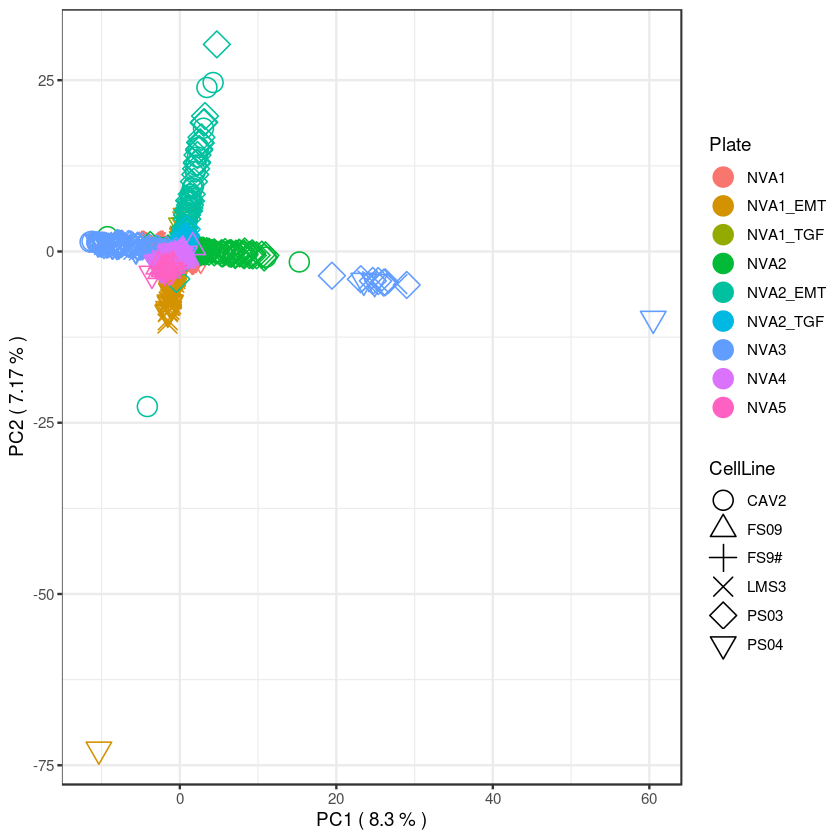

In [669]:
ggplot(PCA_data, aes(PC1,PC2, colour= Plate, shape = CellLine)) +
  geom_point(aes(shape=CellLine), size=5) +
  scale_shape_manual(values=1:nlevels(CellLine))+
  xlab(paste("PC1", "(",round(PCA_TOT$eig[1,2], 2), "% )"))+
  ylab(paste("PC2", "(",round(PCA_TOT$eig[2,2], 2), "% )"))+
  theme_bw()

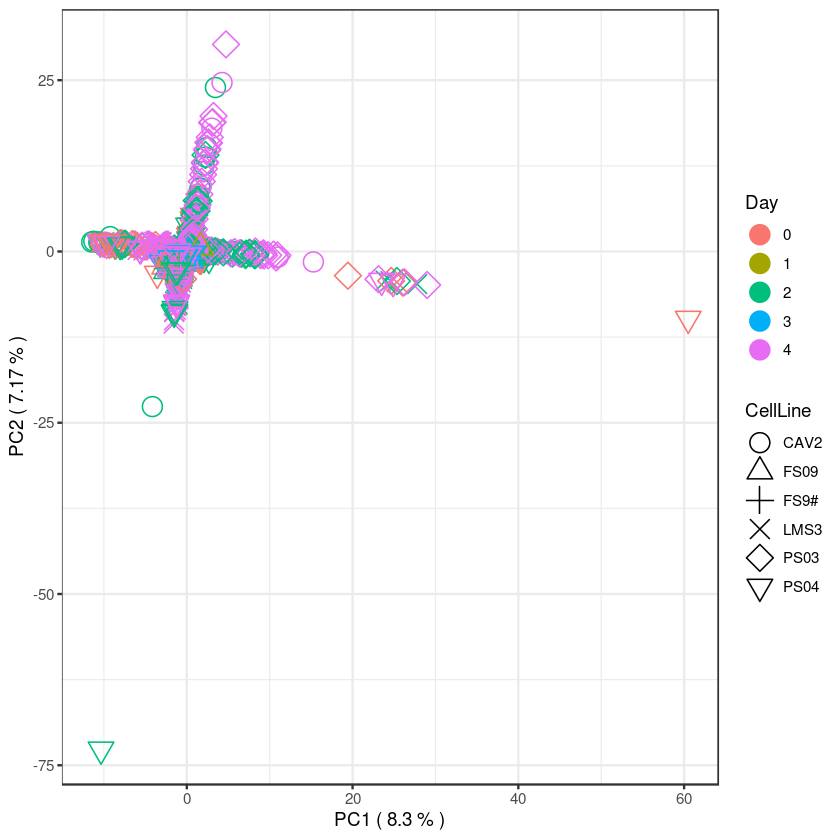

In [670]:
ggplot(PCA_data, aes(PC1,PC2, colour= Day, shape = CellLine)) +
  geom_point(aes(shape=CellLine), size=5) +
  scale_shape_manual(values=1:nlevels(CellLine))+
  xlab(paste("PC1", "(",round(PCA_TOT$eig[1,2], 2), "% )"))+
  ylab(paste("PC2", "(",round(PCA_TOT$eig[2,2], 2), "% )"))+
  theme_bw()

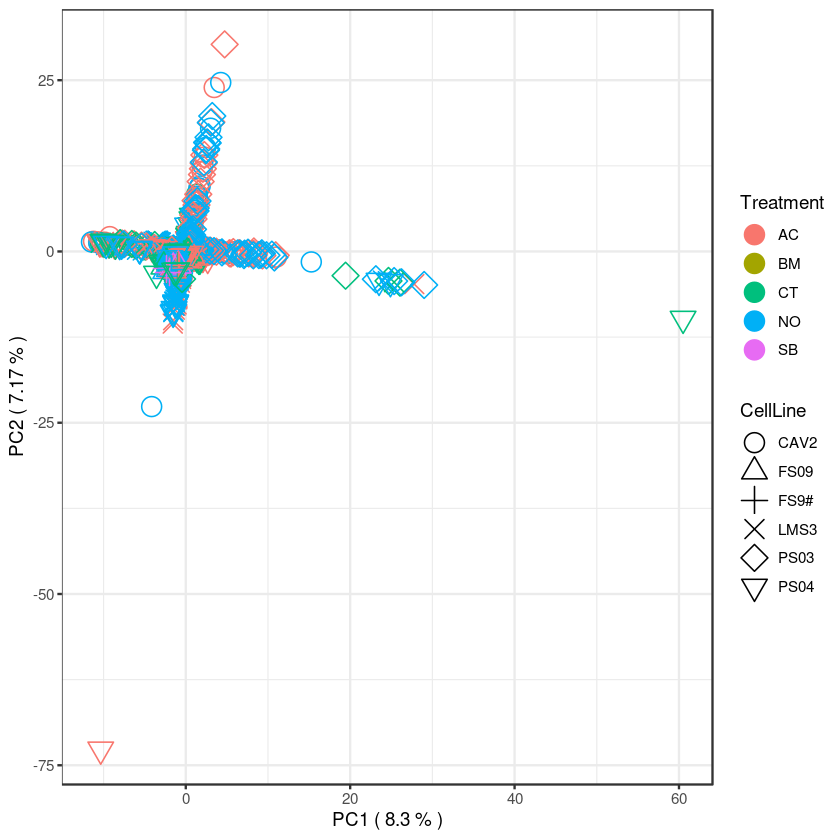

In [671]:
ggplot(PCA_data, aes(PC1,PC2, colour= Treatment, shape = CellLine)) +
  geom_point(aes(shape=CellLine), size=5) +
  scale_shape_manual(values=1:nlevels(CellLine))+
  xlab(paste("PC1", "(",round(PCA_TOT$eig[1,2], 2), "% )"))+
  ylab(paste("PC2", "(",round(PCA_TOT$eig[2,2], 2), "% )"))+
  theme_bw()

1) first normalise NVA2 and NVA3 because they are performed on the same gene set

In [672]:
NVA23 <- rbind.fill(biomark_NVA2,  biomark_NVA3)
dim(NVA23)

[1] 169  86

In [673]:
TABLE <- NVA23

Day <- substring(TABLE$Name,11,11)
CellLine <- as.factor(substring(TABLE$Name,1,4))
Plate <- c(rep("NVA2", nrow(biomark_NVA2)), rep("NVA3", nrow(biomark_NVA3)))


Treatment <- as.factor(substring(TABLE$Name,5,6))


PCA_TOT=PCA(TABLE[,-c(1:2)] , scale.unit=T,ncp=5, axes = c(1,2))

PCAcoord <- as.data.frame(PCA_TOT$ind)
PCAcoord12 <- cbind.data.frame(PCAcoord[,1], PCAcoord[,2])

PCA_data <- cbind.data.frame(PCAcoord12,Day, CellLine, Plate, Treatment)

colnames(PCA_data) <- c("PC1", "PC2", "Day", "CellLine", "Plate", "Treatment")

head(PCA_data)

,PC1,PC2,Day,CellLine,Plate,Treatment
,<dbl>,<dbl>,<chr>,<fct>,<chr>,<fct>
1,0.5682086,-5.193427,2,CAV2,NVA2,AC
2,0.2686368,-4.336935,2,CAV2,NVA2,AC
3,-0.3596306,-3.415816,2,CAV2,NVA2,AC
4,5.9467070,-6.888161,4,CAV2,NVA2,AC
5,0.5716187,-2.996687,4,CAV2,NVA2,AC
6,0.1852631,-2.651899,4,CAV2,NVA2,AC


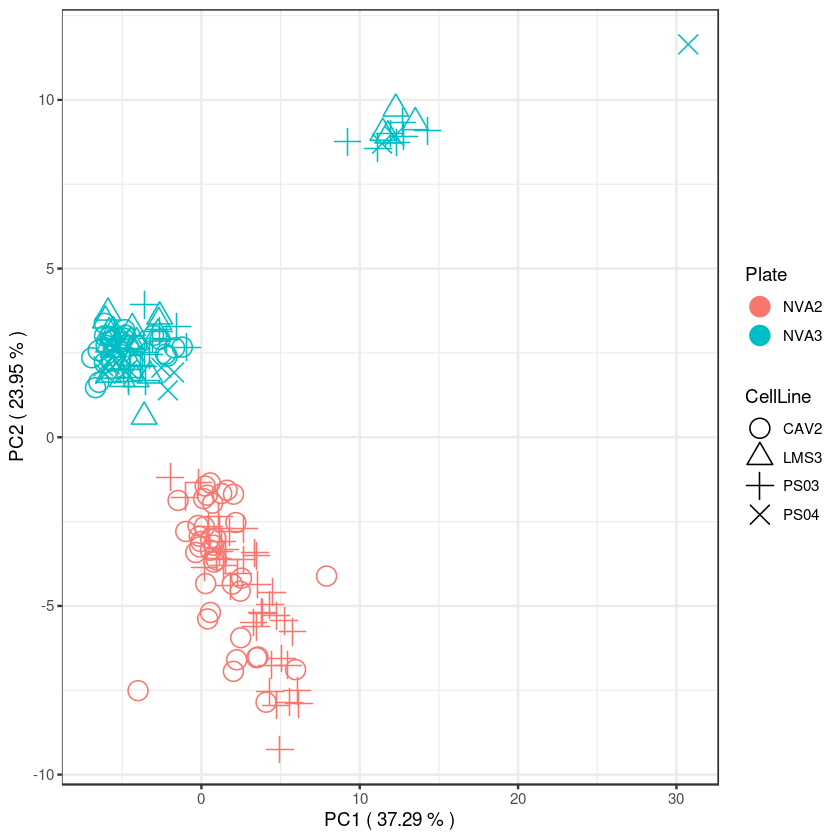

In [674]:
ggplot(PCA_data, aes(PC1,PC2, colour= Plate, shape = CellLine)) +
  geom_point(aes(shape=CellLine), size=5) +
  scale_shape_manual(values=1:nlevels(CellLine))+
  xlab(paste("PC1", "(",round(PCA_TOT$eig[1,2], 2), "% )"))+
  ylab(paste("PC2", "(",round(PCA_TOT$eig[2,2], 2), "% )"))+
  theme_bw()

In [675]:
# Normalisation between the two plates
normalisation_samples <- intersect(biomark_NVA2[["Name"]], biomark_NVA3[["Name"]])
normalisation_samples

normalisation_genes <- intersect(colnames(biomark_NVA2), colnames(biomark_NVA3))
length(normalisation_genes) 
normalisation_genes <- intersect(colnames(biomark_NVA2), colnames(biomark_NVA3))
biomark_NVA2_norm_gene <- biomark_NVA2[,c(which(colnames(biomark_NVA2) %in% normalisation_genes))]
biomark_NVA3_norm_gene <- biomark_NVA3[,c(which(colnames(biomark_NVA3) %in% normalisation_genes))]
dim(biomark_NVA2_norm_gene)
dim(biomark_NVA3_norm_gene)

[1] "CAV2AC100D4A" "CAV2AC100D4B" "CAV2AC100D4C" "CAV2CT000D0A" "CAV2CT000D0B"
 [6] "CAV2CT000D0C" "CAV2NO100D4A" "CAV2NO100D4B" "CAV2NO100D4C" "PS03AC100D4A"
[11] "PS03AC100D4B" "PS03AC100D4C" "PS03CT000D0A" "PS03CT000D0B" "PS03CT000D0C"
[16] "PS03NO100D4A" "PS03NO100D4B" "PS03NO100D4C"

[1] 86

[1] 77 86

[1] 92 86

In [676]:
#Normalisation by gene averages
biomark_NVA3_norm <- biomark_NVA3_norm_gene %>% filter(Name %in% normalisation_samples) %>% arrange(Name)
biomark_NVA2_norm <- biomark_NVA2_norm_gene %>% filter(Name %in% normalisation_samples) %>% arrange(Name)
delta_normalisation_samples <- map2_df(biomark_NVA3_norm[,3:ncol(biomark_NVA3_norm)], 
                                       biomark_NVA2_norm[,3:ncol(biomark_NVA2_norm)], `-`)
normalisation_factors <- delta_normalisation_samples %>% summarise_all(mean)
normalisation_factors

Alb,Apoh,Aqp1,Bmp4,Ccr5,Cd34,Cd3e,Cd79a,Chat,Col10a1,⋯,Slc32a1,Smtn,Sox17,Sox2,Sox7,T,Tat,Tyr,Zfp42,Zic1
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
-1.9644,1.263767,0.6307733,7.581833,-7.14236,-0.8338552,-1.492964,-0.7669396,0.1749471,-2.164492,⋯,-1.036557,1.836155,-1.532274,-1.506316,1.917699,-0.2429942,0.3049437,0.9428913,0.4498704,-1.678336


In [677]:
biomark_NVA3_norm_gene[,3:ncol(biomark_NVA3_norm)] <- sweep(biomark_NVA3_norm_gene[,3:ncol(biomark_NVA3_norm)], 2, unlist(normalisation_factors), FUN="-")

biomark_NVA3_norm_gene <- biomark_NVA3_norm_gene %>% filter(!(Name %in% normalisation_samples))

# attach the two data-sets

biomark_clean23 <- bind_rows(biomark_NVA2_norm_gene, biomark_NVA3_norm_gene)
head(biomark_clean23)
tail(biomark_clean23)
dim(biomark_clean23)

,Plate,Name,Alb,Apoh,Aqp1,Bmp4,Ccr5,Cd34,Cd3e,Cd79a,⋯,Slc32a1,Smtn,Sox17,Sox2,Sox7,T,Tat,Tyr,Zfp42,Zic1
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,NVA2,CAV2AC025D2A,-13.929419,-15.0000,-10.154210,-15.00000,-5.961611,-12.718375,-15.000000,-11.574841,⋯,-7.126698,-14.61622,-13.38133,0.36095332,-12.77636,-2.049060,-15.00000,-15,-15.00000,-8.260323
2,NVA2,CAV2AC025D2B,-12.846441,-15.0000,-8.833229,-15.00000,-6.332856,-11.213959,-15.401889,-10.897416,⋯,-7.107802,-15.00000,-11.97831,-0.06686479,-12.35521,-2.877294,-15.00000,-15,-12.55147,-8.680345
3,NVA2,CAV2AC025D2C,-12.703947,-15.0000,-8.660316,-14.07248,-6.308022,-10.424180,-14.832781,-10.882344,⋯,-7.069234,-15.00000,-16.72026,-0.21036508,-11.88480,-2.764895,-12.80928,-15,-15.00000,-9.063801
4,NVA2,CAV2AC025D4A,-6.818942,-10.9916,-6.840831,-15.00000,-2.591296,-9.225023,-9.860924,-8.836136,⋯,-5.171879,-15.00000,-12.24569,0.52118767,-15.00000,-3.965100,-15.00000,-15,-15.00000,-3.778173
5,NVA2,CAV2AC025D4B,-9.780633,-15.0000,-6.808857,-15.00000,-3.352143,-10.591822,-13.924175,-10.718802,⋯,-6.433067,-15.00000,-13.87352,-1.08224630,-10.62252,-4.519371,-15.00000,-15,-15.00000,-5.750315
6,NVA2,CAV2AC025D4C,-10.139263,-15.0000,-7.523660,-14.16451,-3.830653,-10.430717,-13.493820,-9.283435,⋯,-6.414148,-15.00000,-13.10695,-1.03754602,-11.28862,-4.395879,-15.00000,-15,-14.35768,-5.991447


,Plate,Name,Alb,Apoh,Aqp1,Bmp4,Ccr5,Cd34,Cd3e,Cd79a,⋯,Slc32a1,Smtn,Sox17,Sox2,Sox7,T,Tat,Tyr,Zfp42,Zic1
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
146,NVA3,PS04NO100D2E,-13.035600,-14.214550,-8.653718,-15.21356,-0.1107302,-9.421350,-13.507036,-11.383804,⋯,-9.361562,-16.542977,-13.467726,-0.07678233,-12.456240,-5.613656,-15.304944,-15.942891,-15.449870,-10.2764774
147,NVA3,PS04NO100D4A,-13.035600,-14.286789,-10.513306,-17.32732,-9.0462989,-12.921302,-14.454796,-10.488397,⋯,-5.395007,-14.132448,-13.467726,0.99330414,-14.046562,-12.387614,-15.304944,-15.942891,-15.449870,-7.3959948
148,NVA3,PS04NO100D4C,-13.035600,-14.678803,-10.353039,-17.24210,-7.8576397,-14.166145,-10.808914,-11.245385,⋯,-5.157512,-16.312065,-13.467726,0.84935408,-15.076110,-10.631629,-15.304944,-15.942891,-15.449870,-7.5264196
149,NVA3,PS04NO100D4D,-5.310553,-7.216513,-5.021207,-12.29450,4.1233668,-5.403842,-6.128563,-5.817138,⋯,-4.977621,-8.866561,-5.575713,0.28553422,-8.709535,-5.814385,-6.214035,-6.708405,-7.233760,-0.5752568
150,NVA3,PS04NO100D4E,-12.767420,-16.263767,-7.992943,-14.20637,-3.7527533,-10.735264,-13.507036,-9.400888,⋯,-9.013443,-15.617918,-13.467726,0.16024693,-11.875490,-7.529091,-15.304944,-15.942891,-15.449870,-0.9000883
151,NVA3,PS04NO100D4F,-5.221547,-7.219251,-4.925724,-12.40672,2.8755111,-5.639684,-5.358336,-4.819844,⋯,-4.769496,-8.614366,-4.765844,0.46840466,-8.389181,-5.396977,-6.256837,-6.382774,-6.872993,-0.4198695


[1] 151  86

In [678]:
# Plot TABLES
TABLE1 <- biomark_clean23
TABLE2 <- TABLE1[,-c(1:2)]
rownames(TABLE2) <- TABLE1$Name
TABLE <- TABLE2

Day <- substring(rownames(TABLE),11,11)
CellLine <- as.factor(substring(rownames(TABLE),1,4))
Plate <- c(rep("NVA2", nrow(biomark_NVA2_norm_gene)), rep("NVA3", nrow(biomark_NVA3_norm_gene)))
Treatment <- as.factor(substring(rownames(TABLE),5,6))


PCA_TOT=PCA(TABLE[,-c(1:2)] , scale.unit=T,ncp=5, axes = c(1,2))

PCAcoord <- as.data.frame(PCA_TOT$ind)
PCAcoord12 <- cbind.data.frame(PCAcoord[,1], PCAcoord[,2])

PCA_data <- cbind.data.frame(PCAcoord12,Day, CellLine, Plate, Treatment)

colnames(PCA_data) <- c("PC1", "PC2", "Day", "CellLine", "Plate", "Treatment")

head(PCA_data)

,PC1,PC2,Day,CellLine,Plate,Treatment
,<dbl>,<dbl>,<chr>,<fct>,<chr>,<fct>
1,-2.364951,2.270178,2,CAV2,NVA2,AC
2,-2.676405,2.047215,2,CAV2,NVA2,AC
3,-2.944622,1.297392,2,CAV2,NVA2,AC
4,2.175548,1.016865,4,CAV2,NVA2,AC
5,-2.183705,-1.240147,4,CAV2,NVA2,AC
6,-2.533821,-1.316634,4,CAV2,NVA2,AC


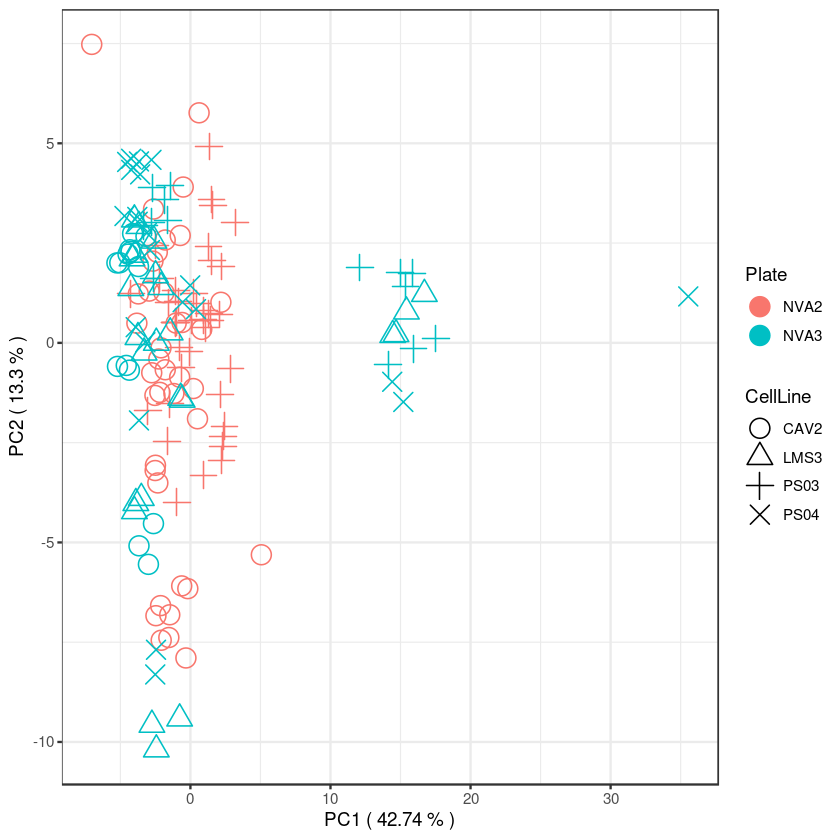

In [679]:
ggplot(PCA_data, aes(PC1,PC2, colour= Plate, shape = CellLine)) +
  geom_point(aes(shape=CellLine), size=5) +
  scale_shape_manual(values=1:nlevels(CellLine))+
  xlab(paste("PC1", "(",round(PCA_TOT$eig[1,2], 2), "% )"))+
  ylab(paste("PC2", "(",round(PCA_TOT$eig[2,2], 2), "% )"))+
  #geom_text_repel(aes(label=colnames(TABLE)))+
  theme_bw()

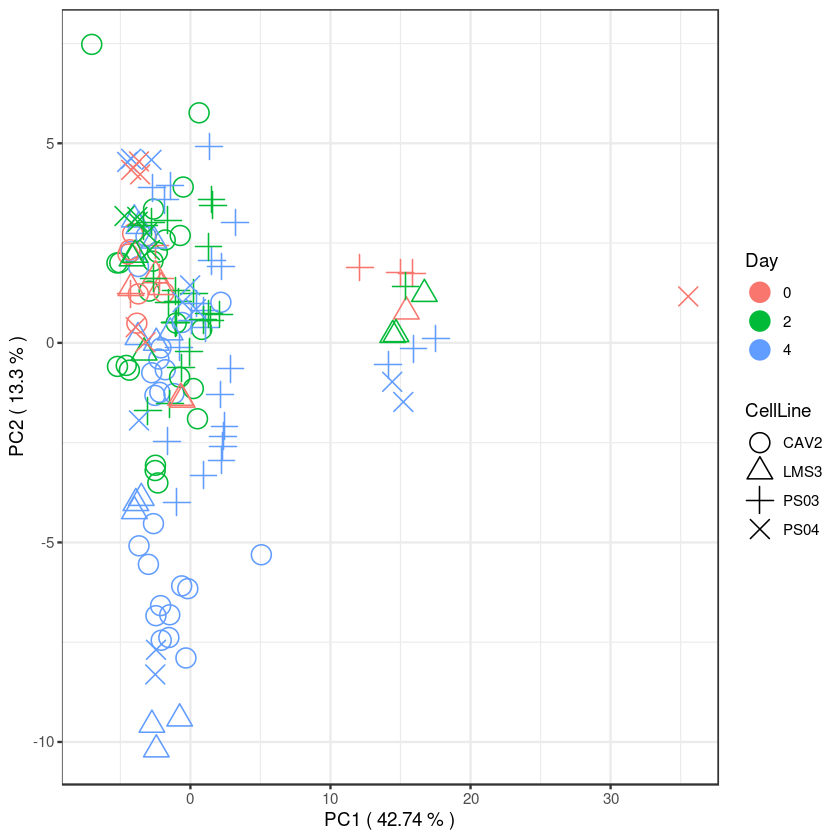

In [680]:
ggplot(PCA_data, aes(PC1,PC2, colour= Day, shape = CellLine)) +
  geom_point(aes(shape=CellLine), size=5) +
  scale_shape_manual(values=1:nlevels(CellLine))+
  xlab(paste("PC1", "(",round(PCA_TOT$eig[1,2], 2), "% )"))+
  ylab(paste("PC2", "(",round(PCA_TOT$eig[2,2], 2), "% )"))+
  #geom_text_repel(aes(label=colnames(TABLE)))+
  theme_bw()

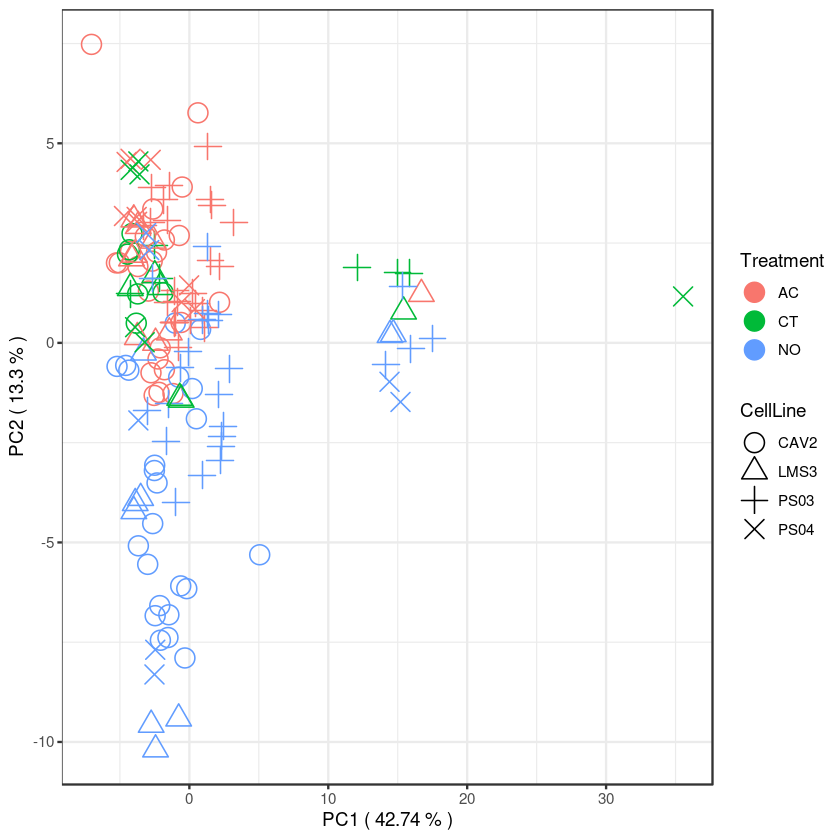

In [681]:
ggplot(PCA_data, aes(PC1,PC2, colour= Treatment, shape = CellLine)) +
  geom_point(aes(shape=CellLine), size=5) +
  scale_shape_manual(values=1:nlevels(CellLine))+
  xlab(paste("PC1", "(",round(PCA_TOT$eig[1,2], 2), "% )"))+
  ylab(paste("PC2", "(",round(PCA_TOT$eig[2,2], 2), "% )"))+
  #geom_text_repel(aes(label=colnames(TABLE)))+
  theme_bw()

2) first normalise NVA2 and NVA3 then normalised with NVA1 because they are from Qiagen albeit different primer set 

In [682]:
# Normalisation between the two plates
normalisation_samples <- intersect(biomark_NVA1[["Name"]], biomark_clean23[["Name"]])
normalisation_samples
normalisation_genes <- intersect(colnames(biomark_NVA1), colnames(biomark_clean23))
length(normalisation_genes) 
biomark_NVA1_norm_gene <- biomark_NVA1[,c(which(colnames(biomark_NVA1) %in% normalisation_genes))]
ncol(biomark_NVA1_norm_gene)
biomark_clean23_norm_gene <- biomark_clean23[,c(which(colnames(biomark_clean23) %in% normalisation_genes))]
ncol(biomark_clean23_norm_gene)

[1] "LMS3AC100D4A" "LMS3AC100D4B" "LMS3AC100D4C" "LMS3AC100D4E" "LMS3AC100D4F"
 [6] "LMS3CT000D0A" "LMS3CT000D0B" "LMS3CT000D0E" "LMS3CT000D0F" "LMS3NO100D4A"
[11] "LMS3NO100D4B" "LMS3NO100D4C" "LMS3NO100D4E" "LMS3NO100D4F" "PS04AC100D4A"
[16] "PS04AC100D4B" "PS04AC100D4C" "PS04AC100D4E" "PS04AC100D4F" "PS04CT000D0A"
[21] "PS04CT000D0B" "PS04CT000D0C" "PS04CT000D0E" "PS04CT000D0F" "PS04NO100D4A"
[26] "PS04NO100D4C" "PS04NO100D4E" "PS04NO100D4F"

[1] 22

[1] 22

[1] 22

In [683]:
#Normalisation by gene averages
biomark_clean23_norm <- biomark_clean23 %>% filter(Name %in% normalisation_samples) %>% arrange(Name)
biomark_clean23_norm <- biomark_clean23_norm[,c(which(colnames(biomark_clean23_norm) %in% normalisation_genes))]

biomark_NVA1_norm <- biomark_NVA1 %>% filter(Name %in% normalisation_samples) %>% arrange(Name)
biomark_NVA1_norm <- biomark_NVA1_norm[,c(which(colnames(biomark_NVA1_norm) %in% normalisation_genes))]

delta_normalisation_samples <- map2_df(biomark_clean23_norm[,3:ncol(biomark_clean23_norm)], biomark_NVA1_norm[,3:ncol(biomark_NVA1_norm)], `-`)
normalisation_factors_2 <- delta_normalisation_samples %>% summarise_all(mean)
normalisation_factors_2

Alb,Fgf5,Gata1,Gata2,Gata6,Gdf3,Gfap,Hand1,Hnf4a,Mixl1,Nanog,Olig2,Otx2,Pou5f1,Sox17,Sox2,Sox7,T,Tat,Zfp42
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1.532937,3.148876,8.221716,-5.022838,2.435036,-0.02526772,-4.549821,1.686214,0.7087167,0.9864162,1.820014,2.537716,1.629374,0.1259181,-11.68734,14.86516,0.1908939,0.8925989,0.6484472,1.088469


In [684]:
biomark_clean23_norm_gene[,3:ncol(biomark_clean23_norm)] <- sweep(biomark_clean23_norm_gene[,3:ncol(biomark_clean23_norm)], 2, unlist(normalisation_factors_2), FUN="-")
biomark_clean23_norm_gene <- biomark_clean23_norm_gene %>% filter(!(Name %in% normalisation_samples))

# attach the two data-sets

biomark_clean123 <- bind_rows(biomark_NVA1_norm_gene, biomark_clean23_norm_gene)
head(biomark_clean123)
tail(biomark_clean123)
dim(biomark_clean123)

,Plate,Name,Alb,Fgf5,Gata1,Gata2,Gata6,Gdf3,Gfap,Hand1,⋯,Nanog,Olig2,Otx2,Pou5f1,Sox17,Sox2,Sox7,T,Tat,Zfp42
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,NVA1,LMS3AC025D2A,-13.87625,-1.667977,-12.79158,-11.137755,-5.915775,-8.722328,-3.388918,-14.86566,⋯,-1.523390,-9.344434,-3.218549,0.8913783,-1.331135,-15.00000,-12.23849,-2.498316,-15.00000,-13.87509
2,NVA1,LMS3AC025D2B,-14.30774,-1.768353,-12.92359,-11.154593,-5.971406,-8.203500,-3.324410,-15.33538,⋯,-1.491077,-10.158595,-3.207072,1.2230291,-1.687327,-15.00000,-12.54289,-2.390660,-18.00453,-13.78454
3,NVA1,LMS3AC025D2C,-14.77774,-1.599629,-13.00271,-11.957169,-5.816322,-8.034493,-2.844446,-14.66951,⋯,-1.658402,-10.580202,-3.169825,0.7228994,-1.883571,-21.80259,-12.38875,-2.035735,-15.00000,-13.75803
4,NVA1,LMS3AC025D4A,-12.98461,-3.275699,-13.45556,-9.446853,-5.688003,-9.770710,-3.452660,-11.66461,⋯,-1.049073,-11.133586,-3.027180,1.0065121,-1.357619,-15.00000,-11.02648,-6.724909,-15.00000,-13.86808
5,NVA1,LMS3AC025D4B,-13.64117,-4.521821,-15.76153,-9.217460,-7.628088,-10.149894,-4.322119,-13.39360,⋯,-1.965148,-10.396095,-3.508844,0.7765034,-1.550885,-15.00000,-12.51317,-6.027038,-15.00000,-17.86430
6,NVA1,LMS3AC025D4C,-13.97276,-4.552419,-14.24961,-10.033617,-7.696850,-10.099433,-4.504905,-12.11784,⋯,-1.874500,-10.518033,-3.505989,0.6016185,-1.564005,-15.00000,-11.97591,-6.182131,-16.83572,-14.40239


,Plate,Name,Alb,Fgf5,Gata1,Gata2,Gata6,Gdf3,Gfap,Hand1,⋯,Nanog,Olig2,Otx2,Pou5f1,Sox17,Sox2,Sox7,T,Tat,Zfp42
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
212,NVA3,PS04AC100D2F,-14.56854,-5.610672,-16.257370,-10.136999,-8.214134,-7.208184,-8.735769,-14.131779,⋯,-3.401137,-14.478013,-1.562563,-0.245018818,-1.780386,-15.80321,-12.075506,-8.641558,-15.953391,-13.353849
213,NVA3,PS04AC100D4D,-13.45936,-2.920259,-14.045589,-13.040598,-9.396894,-6.275588,-11.371511,-15.407240,⋯,-2.031170,-14.478013,-2.272285,-0.009053121,-1.780386,-16.37880,-11.388741,-3.367145,-15.953391,-14.695039
214,NVA3,PS04CT000D0D,-11.56693,-3.825494,-13.446741,-10.028790,-6.515722,-6.912357,-9.086199,-16.165130,⋯,-4.038818,-14.478013,-2.963553,-0.791594093,-2.347136,-17.05827,-13.928948,-5.674386,-21.035459,-15.807754
215,NVA3,PS04NO100D2D,-14.56854,-6.120227,-13.753685,-9.443379,-7.777777,-7.856466,-10.621578,-16.165130,⋯,-3.976071,-13.384006,-1.295568,-1.163022319,-1.780386,-15.26469,-13.118078,-8.826757,-15.953391,-14.465010
216,NVA3,PS04NO100D2E,-14.56854,-6.981637,-12.537129,-7.956251,-8.144118,-7.426699,-8.152398,-16.165130,⋯,-4.230578,-13.227449,-1.151891,-1.193960364,-1.780386,-14.94195,-12.647134,-6.506255,-15.953391,-16.538340
217,NVA3,PS04NO100D4D,-6.84349,-6.552848,-7.957725,-7.435538,-7.943311,-7.041993,-4.690207,-6.375076,⋯,-5.324406,-6.168064,-2.104462,-3.491797219,6.111628,-14.57963,-8.900429,-6.706984,-6.862482,-8.322229


[1] 217  22

In [685]:
# Plot TABLES
TABLE1 <- biomark_clean123
TABLE2 <- TABLE1[,-c(1:2)]
rownames(TABLE2) <- TABLE1$Name
TABLE <- TABLE2

Day <- substring(rownames(TABLE),11,11)
CellLine <- as.factor(substring(rownames(TABLE),1,4))
Plate <- c(rep("NVA1", nrow(biomark_NVA1_norm_gene)), rep("NVA23", nrow(biomark_clean23_norm_gene)))
Treatment <- as.factor(substring(rownames(TABLE),5,6))


PCA_TOT=PCA(TABLE[,-c(1:2)] , scale.unit=T,ncp=5, axes = c(1,2))

PCAcoord <- as.data.frame(PCA_TOT$ind)
PCAcoord12 <- cbind.data.frame(PCAcoord[,1], PCAcoord[,2])

PCA_data <- cbind.data.frame(PCAcoord12,Day, CellLine, Plate, Treatment)

colnames(PCA_data) <- c("PC1", "PC2", "Day", "CellLine", "Plate", "Treatment")

head(PCA_data)

,PC1,PC2,Day,CellLine,Plate,Treatment
,<dbl>,<dbl>,<chr>,<fct>,<chr>,<fct>
1,2.4073347,-1.5844811,2,LMS3,NVA1,AC
2,1.9407124,-2.4600978,2,LMS3,NVA1,AC
3,3.1078001,-2.8499720,2,LMS3,NVA1,AC
4,2.0059257,-0.5509870,4,LMS3,NVA1,AC
5,0.2763439,-1.1562744,4,LMS3,NVA1,AC
6,0.8439635,-0.8330254,4,LMS3,NVA1,AC


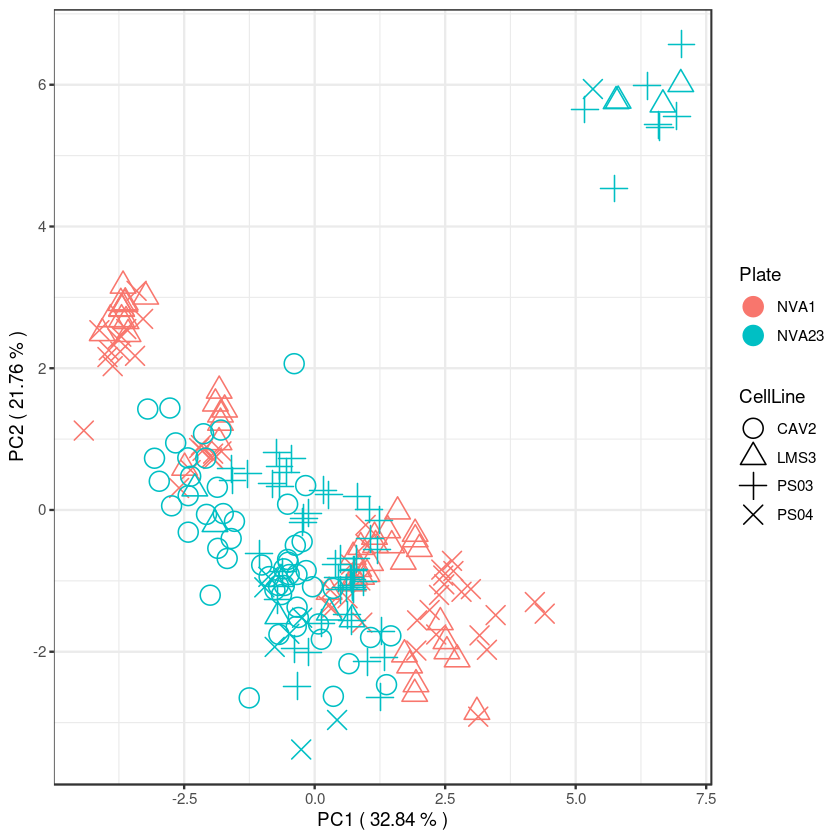

In [686]:
ggplot(PCA_data, aes(PC1,PC2, colour= Plate, shape = CellLine)) +
  geom_point(aes(shape=CellLine), size=5) +
  scale_shape_manual(values=1:nlevels(CellLine))+
  xlab(paste("PC1", "(",round(PCA_TOT$eig[1,2], 2), "% )"))+
  ylab(paste("PC2", "(",round(PCA_TOT$eig[2,2], 2), "% )"))+
  #geom_text_repel(aes(label=colnames(TABLE)))+
  theme_bw()

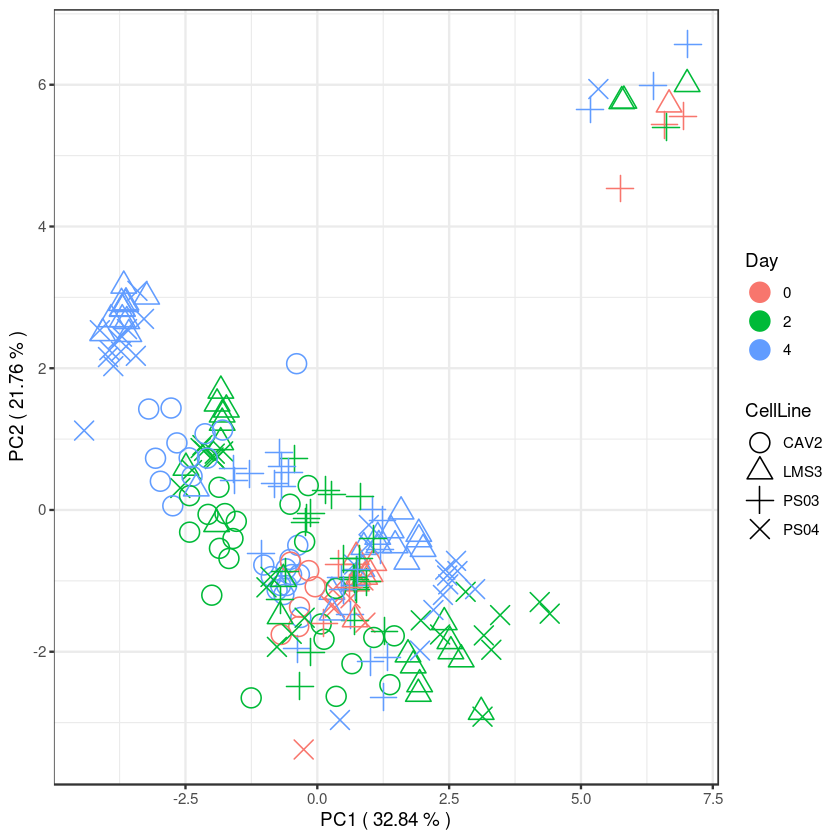

In [687]:
ggplot(PCA_data, aes(PC1,PC2, colour= Day, shape = CellLine)) +
  geom_point(aes(shape=CellLine), size=5) +
  scale_shape_manual(values=1:nlevels(CellLine))+
  xlab(paste("PC1", "(",round(PCA_TOT$eig[1,2], 2), "% )"))+
  ylab(paste("PC2", "(",round(PCA_TOT$eig[2,2], 2), "% )"))+
  #geom_text_repel(aes(label=colnames(TABLE)))+
  theme_bw()

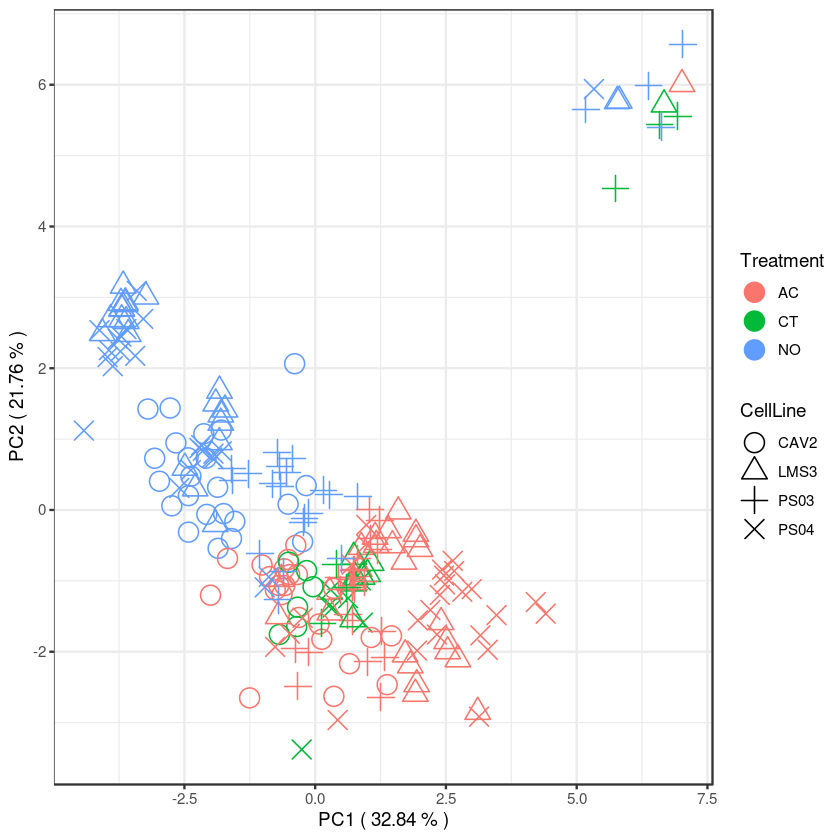

In [688]:
ggplot(PCA_data, aes(PC1,PC2, colour= Treatment, shape = CellLine)) +
  geom_point(aes(shape=CellLine), size=5) +
  scale_shape_manual(values=1:nlevels(CellLine))+
  xlab(paste("PC1", "(",round(PCA_TOT$eig[1,2], 2), "% )"))+
  ylab(paste("PC2", "(",round(PCA_TOT$eig[2,2], 2), "% )"))+
  #geom_text_repel(aes(label=colnames(TABLE)))+
  theme_bw()

3) Normalise NVA4 and NVA5

In [689]:
NVA45 <- rbind.fill(biomark_NVA4, biomark_NVA5)
dim(NVA45)

[1] 105  96

In [690]:
TABLE <- NVA45

Day <- substring(TABLE$Name,11.11)
CellLine <- as.factor(substring(TABLE$Name,1,4))
Plate <- c(rep("NVA4", nrow(biomark_NVA4)), rep("NVA5", nrow(biomark_NVA5)))


Treatment <- as.factor(substring(TABLE$Name,5,6))


PCA_TOT=PCA(TABLE[,-c(1:2)] , scale.unit=T,ncp=5, axes = c(1,2))

PCAcoord <- as.data.frame(PCA_TOT$ind)
PCAcoord12 <- cbind.data.frame(PCAcoord[,1], PCAcoord[,2])

PCA_data <- cbind.data.frame(PCAcoord12,Day, CellLine, Plate, Treatment)

colnames(PCA_data) <- c("PC1", "PC2", "Day", "CellLine", "Plate", "Treatment")

head(PCA_data)

Warning message in PCA(TABLE[, -c(1:2)], scale.unit = T, ncp = 5, axes = c(1, 2)):
“Missing values are imputed by the mean of the variable: you should use the imputePCA function of the missMDA package”


,PC1,PC2,Day,CellLine,Plate,Treatment
,<dbl>,<dbl>,<chr>,<fct>,<chr>,<fct>
1,-5.268419,4.5024053,1A,FS09,NVA4,AC
2,2.101334,0.3852635,1B,FS09,NVA4,AC
3,-1.508323,5.1906924,1C,FS09,NVA4,AC
4,-1.456629,6.5296379,2A,FS09,NVA4,AC
5,2.324904,3.0157114,2B,FS09,NVA4,AC
6,-1.704161,6.4189996,2C,FS09,NVA4,AC


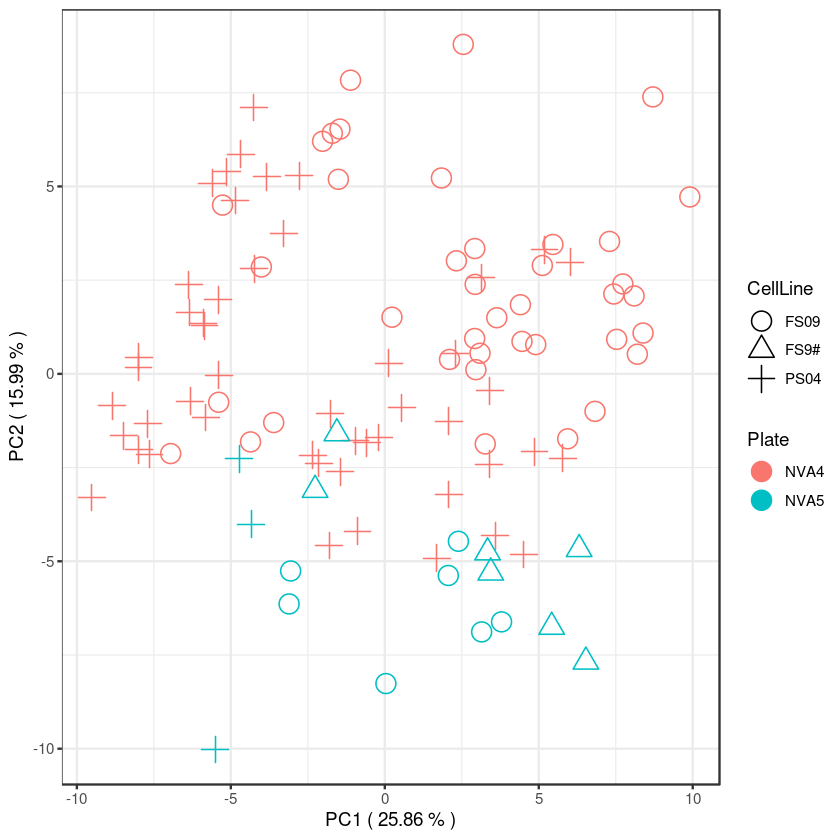

In [691]:
ggplot(PCA_data, aes(PC1,PC2, colour= Plate, shape = CellLine)) +
  geom_point(aes(shape=CellLine), size=5) +
  scale_shape_manual(values=1:nlevels(CellLine))+
  xlab(paste("PC1", "(",round(PCA_TOT$eig[1,2], 2), "% )"))+
  ylab(paste("PC2", "(",round(PCA_TOT$eig[2,2], 2), "% )"))+
  theme_bw()

In [692]:
# Normalisation between the two plates
normalisation_samples <- intersect(biomark_NVA4[["Name"]], biomark_NVA5[["Name"]])
normalisation_samples
normalisation_genes <- intersect(colnames(biomark_NVA4), colnames(biomark_NVA5))
length(normalisation_genes) 
biomark_NVA4_norm_gene <- biomark_NVA4[,c(which(colnames(biomark_NVA4) %in% normalisation_genes))]
ncol(biomark_NVA4_norm_gene)
biomark_NVA5_norm_gene <- biomark_NVA5[,c(which(colnames(biomark_NVA5) %in% normalisation_genes))]
ncol(biomark_NVA5_norm_gene )

[1] "PS04CT000D0G" "PS04CT000D2H" "PS04CT000D2I"

[1] 94

[1] 94

[1] 94

In [693]:
#Normalisation by gene averages
biomark_NVA5_norm <- biomark_NVA5 %>% filter(Name %in% normalisation_samples) %>% arrange(Name)
biomark_NVA5_norm <- biomark_NVA5_norm[,c(which(colnames(biomark_NVA5_norm) %in% normalisation_genes))]

biomark_NVA4_norm <- biomark_NVA4 %>% filter(Name %in% normalisation_samples) %>% arrange(Name)
biomark_NVA4_norm <- biomark_NVA4_norm[,c(which(colnames(biomark_NVA4_norm) %in% normalisation_genes))]

delta_normalisation_samples <- map2_df(biomark_NVA5_norm[,3:ncol(biomark_NVA5_norm)], biomark_NVA4_norm[,3:ncol(biomark_NVA4_norm)], `-`)
normalisation_factors_3 <- delta_normalisation_samples %>% summarise_all(mean)
normalisation_factors_3

Acvr1,Acvr2,Axin2,Bmp2,Bmp4,Bmpr1a,Bmpr1b,Cdc42,Cdh1,Cdh2,⋯,Tgfbr2,Thy1,Twist1,Vim,Wnt11,Wnt3,Wnt3a,Wnt5a,Zfp42,Zic1
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.07820292,-1.061711,-0.01269842,1.266523,1.53618,-0.1999922,-0.9117185,-0.2823085,-0.2839746,-1.343078,⋯,-0.2921049,0.01775889,-1.317106,0.1263892,0.9824667,1.072846,1.777032,-4.407503,-3.73871,-0.2383383


In [694]:
biomark_NVA5_norm_gene[,3:ncol(biomark_NVA5_norm)] <- sweep(biomark_NVA5_norm_gene[,3:ncol(biomark_NVA5_norm)], 2, unlist(normalisation_factors_3), FUN="-")
biomark_NVA5_norm_gene <- biomark_NVA5_norm_gene %>% filter(!(Name %in% normalisation_samples))

# attach the two data-sets

biomark_clean45 <- bind_rows(biomark_NVA4_norm_gene, biomark_NVA5_norm_gene)
head(biomark_clean45)
tail(biomark_clean45)
dim(biomark_clean45)

,Plate,Name,Acvr1,Acvr2,Axin2,Bmp2,Bmp4,Bmpr1a,Bmpr1b,Cdc42,⋯,Tgfbr2,Thy1,Twist1,Vim,Wnt11,Wnt3,Wnt3a,Wnt5a,Zfp42,Zic1
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,NVA4,FS09AC100D1A,-8.047635,-5.466908,-5.252431,-8.970626,-8.610463,-3.880671,-15.000000,-2.003215,⋯,-9.616727,-7.832940,-7.548131,0.02804561,-8.381068,-4.735817,-11.666082,-11.427247,-13.278503,-9.145212
2,NVA4,FS09AC100D1B,-8.124824,-4.128133,-3.668131,-12.343638,-9.841501,-3.435122,-9.982412,-1.662324,⋯,-10.045333,-10.520544,-9.119020,-0.88736292,-10.385905,-5.173640,-8.797217,-12.044410,-14.790580,-6.055286
3,NVA4,FS09AC100D1C,-6.767786,-4.268709,-3.626705,-9.383836,-9.652584,-3.274913,-11.310626,-1.728957,⋯,-9.837450,-8.707233,-8.006842,0.13365095,-7.897569,-4.147540,-7.823813,-11.087571,-11.534256,-6.131061
4,NVA4,FS09AC100D2A,-7.273403,-4.113074,-4.393609,-8.966985,-11.358024,-3.247771,-15.000000,-1.665782,⋯,-9.626413,-9.051868,-8.226870,-0.19021359,-7.718373,-5.042554,-10.055242,-9.725474,-9.782931,-5.860447
5,NVA4,FS09AC100D2B,-6.833417,-3.844111,-3.645294,-11.232134,-9.414661,-3.334055,-12.088272,-1.252989,⋯,-10.814523,-11.000267,-9.342363,-0.61289318,-9.979785,-5.029816,-9.806425,-11.639969,-11.142726,-4.902722
6,NVA4,FS09AC100D2C,-7.287710,-4.649117,-4.563544,-9.234566,-8.696048,-3.535151,-10.837537,-1.584293,⋯,-10.432160,-8.851122,-7.777898,-0.28441586,-8.201642,-4.608086,-10.786721,-10.677736,-8.837982,-6.382842


,Plate,Name,Acvr1,Acvr2,Axin2,Bmp2,Bmp4,Bmpr1a,Bmpr1b,Cdc42,⋯,Tgfbr2,Thy1,Twist1,Vim,Wnt11,Wnt3,Wnt3a,Wnt5a,Zfp42,Zic1
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
97,NVA5,FS9#AC100D2D,-8.182150,-3.902377,-5.850159,-9.760669,-11.65605,-3.121929,-9.901185,-2.005334,⋯,-9.785435,-10.392822,-8.936247,-0.59704548,-10.66980,-8.371520,-9.460594,-12.33570,-10.354440,-6.640458
98,NVA5,FS9#NO100D2D,-8.808154,-3.385538,-5.808978,-14.839333,-12.57013,-3.163162,-9.336044,-2.081065,⋯,-10.597869,-9.137373,-9.134542,-0.41177605,-12.79797,-9.165112,-12.627265,-12.16040,-3.653230,-10.771002
99,NVA5,FS9#SB001D2D,-8.626948,-3.348656,-5.955533,-16.266523,-14.72808,-2.884219,-9.717912,-1.675206,⋯,-9.707346,-10.399710,-8.176972,-0.30854441,-14.43771,-9.233395,-13.174101,-13.60900,-10.301173,-9.566649
100,NVA5,FS9#AC100D4D,-8.361679,-4.561079,-6.465945,-10.258698,-10.28695,-3.980287,-11.423100,-2.366550,⋯,-14.016684,-8.474257,-7.132092,-1.51100706,-10.67544,-9.057252,-13.631106,-12.77415,-8.316743,-7.747559
101,NVA5,FS9#NO100D4D,-9.054261,-3.162190,-6.373792,-14.896294,-11.95957,-3.868821,-9.775162,-2.372860,⋯,-12.844280,-10.479146,-9.149945,0.08882328,-13.68485,-9.642465,-14.143650,-10.59250,-4.169562,-14.333671
102,NVA5,FS9#SB001D4D,-8.917297,-2.979320,-6.583765,-17.679722,-12.78495,-3.525475,-9.003911,-2.546117,⋯,-13.495042,-12.310627,-7.532438,-0.76865992,-15.35238,-10.041835,-13.109716,-12.49750,-7.525133,-10.299216


[1] 102  94

In [695]:
# Plot TABLES
TABLE1 <- biomark_clean45
TABLE2 <- TABLE1[,-c(1:2)]
rownames(TABLE2) <- TABLE1$Name
TABLE <- TABLE2

Day <- substring(rownames(TABLE),11,11)
CellLine <- as.factor(substring(rownames(TABLE),1,4))
Plate <- c(rep("NVA4", nrow(biomark_NVA4_norm_gene)), rep("NVA5", nrow(biomark_NVA5_norm_gene)))
Treatment <- as.factor(substring(rownames(TABLE),5,6))


PCA_TOT=PCA(TABLE[,-c(1:2)] , scale.unit=T,ncp=5, axes = c(1,2))

PCAcoord <- as.data.frame(PCA_TOT$ind)
PCAcoord12 <- cbind.data.frame(PCAcoord[,1], PCAcoord[,2])

PCA_data <- cbind.data.frame(PCAcoord12,Day, CellLine, Plate, Treatment)

colnames(PCA_data) <- c("PC1", "PC2", "Day", "CellLine", "Plate", "Treatment")

head(PCA_data)

,PC1,PC2,Day,CellLine,Plate,Treatment
,<dbl>,<dbl>,<chr>,<fct>,<chr>,<fct>
1,6.3780526,4.0291416,1,FS09,NVA4,AC
2,-0.7583236,0.5430692,1,FS09,NVA4,AC
3,3.1823553,5.6927866,1,FS09,NVA4,AC
4,3.0268363,6.3597450,2,FS09,NVA4,AC
5,-0.6350546,3.8081330,2,FS09,NVA4,AC
6,3.0221322,6.2399083,2,FS09,NVA4,AC


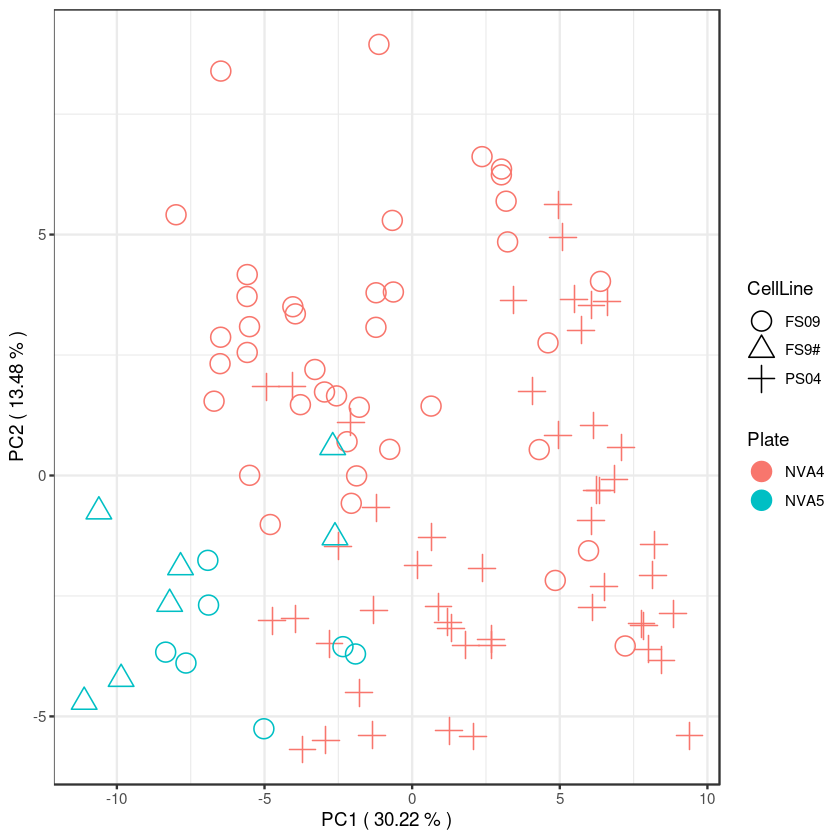

In [696]:
ggplot(PCA_data, aes(PC1,PC2, colour= Plate, shape = CellLine)) +
  geom_point(aes(shape=CellLine), size=5) +
  scale_shape_manual(values=1:nlevels(CellLine))+
  xlab(paste("PC1", "(",round(PCA_TOT$eig[1,2], 2), "% )"))+
  ylab(paste("PC2", "(",round(PCA_TOT$eig[2,2], 2), "% )"))+
  #geom_text_repel(aes(label=colnames(TABLE)))+
  theme_bw()

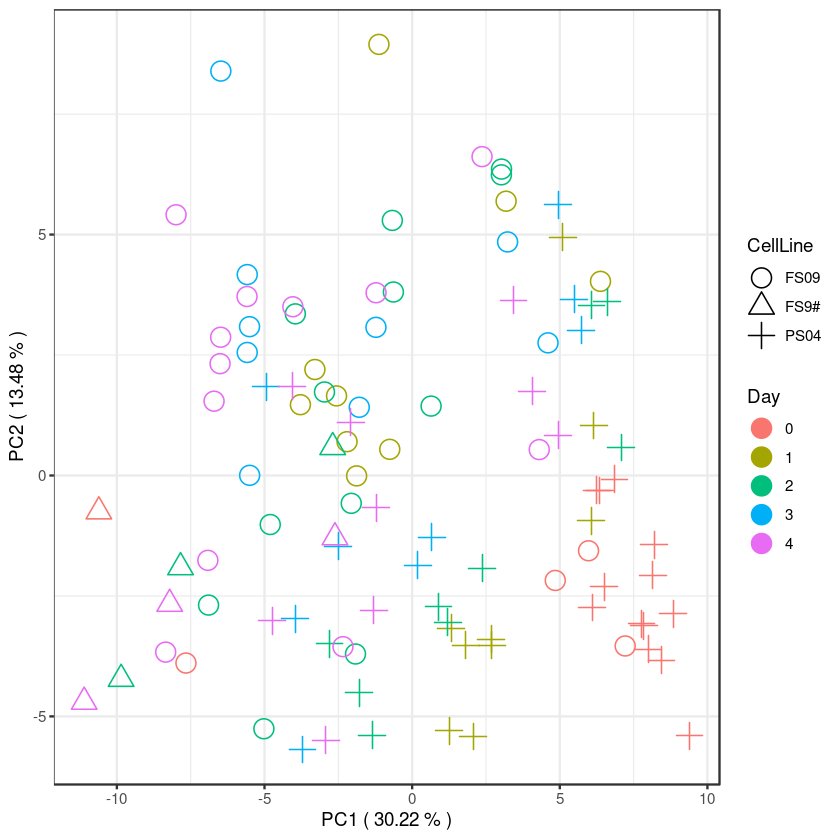

In [697]:
ggplot(PCA_data, aes(PC1,PC2, colour= Day, shape = CellLine)) +
  geom_point(aes(shape=CellLine), size=5) +
  scale_shape_manual(values=1:nlevels(CellLine))+
  xlab(paste("PC1", "(",round(PCA_TOT$eig[1,2], 2), "% )"))+
  ylab(paste("PC2", "(",round(PCA_TOT$eig[2,2], 2), "% )"))+
  #geom_text_repel(aes(label=colnames(TABLE)))+
  theme_bw()

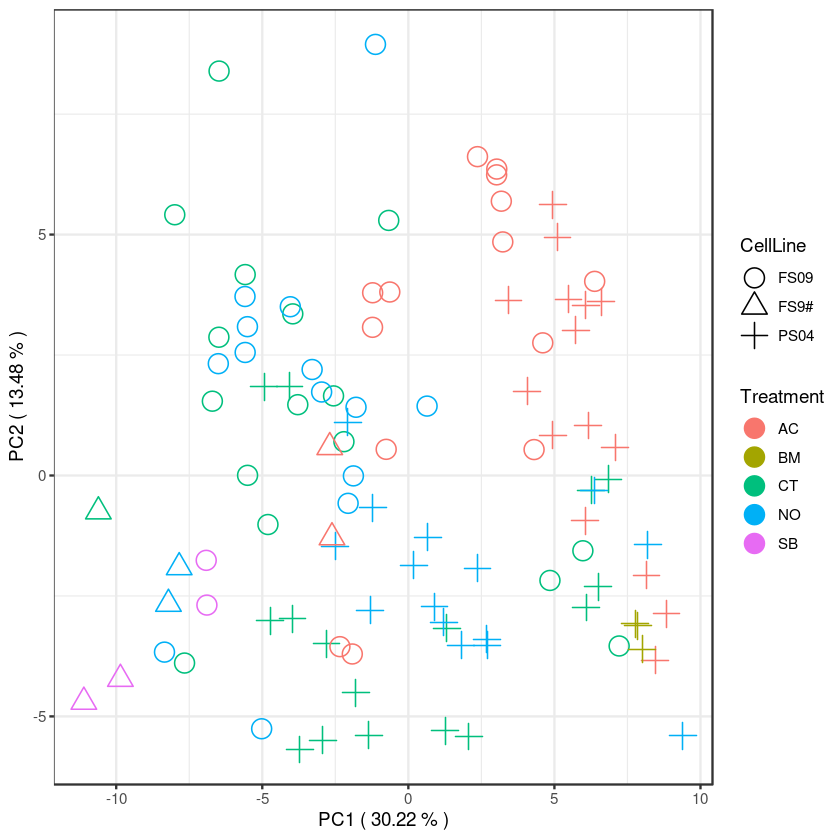

In [698]:
ggplot(PCA_data, aes(PC1,PC2, colour= Treatment, shape = CellLine)) +
  geom_point(aes(shape=CellLine), size=5) +
  scale_shape_manual(values=1:nlevels(CellLine))+
  xlab(paste("PC1", "(",round(PCA_TOT$eig[1,2], 2), "% )"))+
  ylab(paste("PC2", "(",round(PCA_TOT$eig[2,2], 2), "% )"))+
  #geom_text_repel(aes(label=colnames(TABLE)))+
  theme_bw()

4) Normalise NVA123 with NVA45

In [699]:
NVA123_45 <- rbind.fill(biomark_clean123, biomark_clean45)
dim(NVA123_45)

[1] 319  97

In [700]:
TABLE <- NVA123_45

Day <- substring(TABLE$Name,11,11)
CellLine <- as.factor(substring(TABLE$Name,1,4))
Plate <- c(rep("NVA123", nrow(biomark_clean123)), rep("NVA45", nrow(biomark_clean45)))


Treatment <- as.factor(substring(TABLE$Name,5,6))


PCA_TOT=PCA(TABLE[,-c(1:2)] , scale.unit=T,ncp=5, axes = c(1,2))

PCAcoord <- as.data.frame(PCA_TOT$ind)
PCAcoord12 <- cbind.data.frame(PCAcoord[,1], PCAcoord[,2])

PCA_data <- cbind.data.frame(PCAcoord12,Day, CellLine, Plate, Treatment)

colnames(PCA_data) <- c("PC1", "PC2", "Day", "CellLine", "Plate", "Treatment")

head(PCA_data)

Warning message in PCA(TABLE[, -c(1:2)], scale.unit = T, ncp = 5, axes = c(1, 2)):
“Missing values are imputed by the mean of the variable: you should use the imputePCA function of the missMDA package”


,PC1,PC2,Day,CellLine,Plate,Treatment
,<dbl>,<dbl>,<chr>,<fct>,<chr>,<fct>
1,-0.8087914,1.0266127,2,LMS3,NVA123,AC
2,-0.8570030,0.9412700,2,LMS3,NVA123,AC
3,-0.9313050,1.1082206,2,LMS3,NVA123,AC
4,-0.6098838,0.8580268,4,LMS3,NVA123,AC
5,-0.4935497,0.4607654,4,LMS3,NVA123,AC
6,-0.4381599,0.5233908,4,LMS3,NVA123,AC


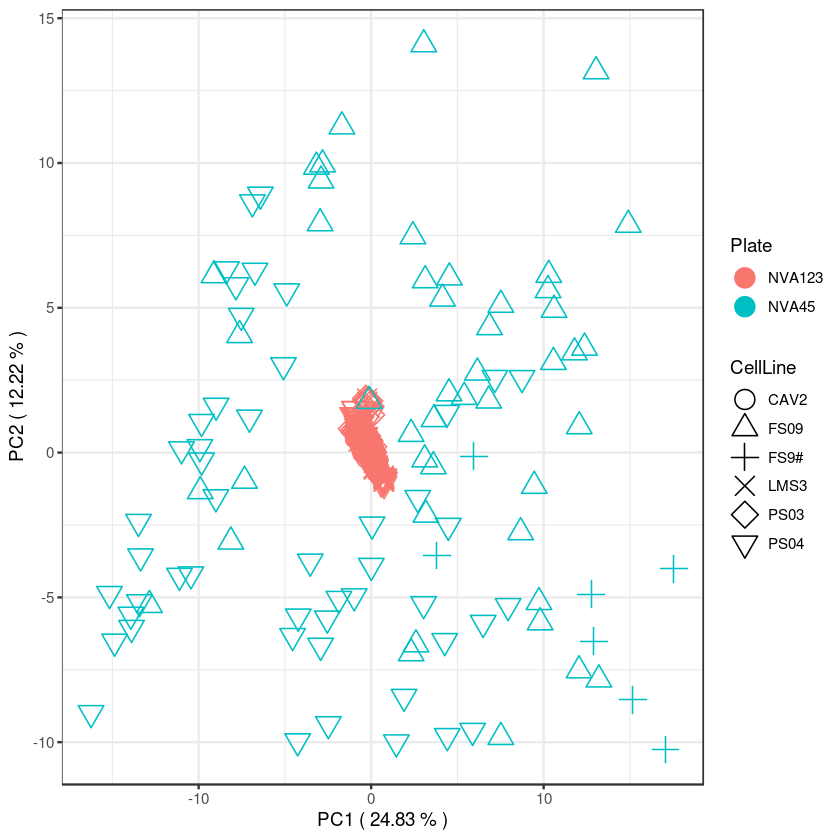

In [701]:
ggplot(PCA_data, aes(PC1,PC2, colour= Plate, shape = CellLine)) +
  geom_point(aes(shape=CellLine), size=5) +
  scale_shape_manual(values=1:nlevels(CellLine))+
  xlab(paste("PC1", "(",round(PCA_TOT$eig[1,2], 2), "% )"))+
  ylab(paste("PC2", "(",round(PCA_TOT$eig[2,2], 2), "% )"))+
  #geom_text_repel(aes(label=colnames(TABLE)))+
  theme_bw()

In [702]:
intersect(biomark_clean123$Name, biomark_clean45$Name)

[1] "PS04AC100D4G" "PS04CT000D0G" "PS04NO100D4G"

In [703]:
colnames(biomark_clean123)
colnames(biomark_clean45)
intersect(colnames(biomark_clean123), colnames(biomark_clean45))
length(intersect(colnames(biomark_clean123), colnames(biomark_clean45)))

[1] "Plate"  "Name"   "Alb"    "Fgf5"   "Gata1"  "Gata2"  "Gata6"  "Gdf3"  
 [9] "Gfap"   "Hand1"  "Hnf4a"  "Mixl1"  "Nanog"  "Olig2"  "Otx2"   "Pou5f1"
[17] "Sox17"  "Sox2"   "Sox7"   "T"      "Tat"    "Zfp42"

[1] "Plate"   "Name"    "Acvr1"   "Acvr2"   "Axin2"   "Bmp2"    "Bmp4"   
 [8] "Bmpr1a"  "Bmpr1b"  "Cdc42"   "Cdh1"    "Cdh2"    "Cer1"    "Ddr2"   
[15] "Dkk1"    "Dppa2"   "Dppa3"   "Dppa5"   "Dsp"     "Dvl1"    "Esrrb"  
[22] "FGF10"   "Fgf5"    "FLAGMIX" "Flk1"    "Foxa2"   "FoxD4"   "Fzd7"   
[29] "Gata1"   "Gata2"   "Gata6"   "Gbx2"    "Gfap"    "Gsc"     "Gsk3b"  
[36] "Hand1"   "Hesx1"   "Hnf4a"   "Hoxd9"   "Klf4"    "Krt1-19" "Lef1"   
[43] "Lhx1"    "Mesp1"   "Mixl1"   "Nanog"   "Nes"     "NeuroD1" "Nkx2-5" 
[50] "Nodal"   "Olig2"   "Otx2"    "Pax6"    "Pcolce"  "Pdgfra"  "Pdgfrb" 
[57] "Pdx1"    "Pitx2"   "Pkd2"    "Porcn"   "Pou5f1"  "Rbm46"   "Rbm47"  
[64] "Rgs2"    "Rhou"    "Smad1"   "Smad2"   "Smad4"   "Smad5"   "Snail2" 
[71] "Sostdc1" "Sox17"   "Sox2"    "Sox7"    "Spp1"    "T"       "Tbp"    
[78] "Tcf4"    "Tcf7"    "Tfpi2"   "Tgfb2"   "Tgfb3"   "Tgfbi"   "Tgfbr1" 
[85] "Tgfbr2"  "Thy1"    "Twist1"  "Vim"     "Wnt11"   "Wnt3"    "Wnt3a"  
[92] "Wnt5a"   "Zfp42"   "Zic1"

[1] "Plate"  "Name"   "Fgf5"   "Gata1"  "Gata2"  "Gata6"  "Gfap"   "Hand1" 
 [9] "Hnf4a"  "Mixl1"  "Nanog"  "Olig2"  "Otx2"   "Pou5f1" "Sox17"  "Sox2"  
[17] "Sox7"   "T"      "Zfp42"

[1] 19

In [704]:
# Normalisation between the two plates
normalisation_samples <- intersect(biomark_clean123[["Name"]], biomark_clean45[["Name"]])
normalisation_samples
normalisation_genes <- intersect(colnames(biomark_clean123), colnames(biomark_clean45))
length(normalisation_genes) 
biomark_clean123_norm_gene <- biomark_clean123[,c(which(colnames(biomark_clean123) %in% normalisation_genes))]
ncol(biomark_clean123_norm_gene)
biomark_clean45_norm_gene <- biomark_clean45[,c(which(colnames(biomark_clean45) %in% normalisation_genes))]
ncol(biomark_clean45_norm_gene)

[1] "PS04AC100D4G" "PS04CT000D0G" "PS04NO100D4G"

[1] 19

[1] 19

[1] 19

In [705]:
#Normalisation by gene averages
biomark_clean45_norm <- biomark_clean45 %>% filter(Name %in% normalisation_samples) %>% arrange(Name)
biomark_clean45_norm <- biomark_clean45_norm[,c(which(colnames(biomark_clean45_norm) %in% normalisation_genes))]

biomark_clean123_norm <- biomark_clean123 %>% filter(Name %in% normalisation_samples) %>% arrange(Name)
biomark_clean123_norm <- biomark_clean123_norm[,c(which(colnames(biomark_clean123_norm) %in% normalisation_genes))]

delta_normalisation_samples <- map2_df(biomark_clean45_norm[,3:ncol(biomark_clean45_norm)], biomark_clean123_norm[,3:ncol(biomark_clean123_norm)], `-`)
normalisation_factors_4 <- delta_normalisation_samples %>% summarise_all(mean)
normalisation_factors_4

length(normalisation_factors_4)
ncol(biomark_clean123_norm)
ncol(biomark_clean45_norm)

Fgf5,Gata1,Gata2,Gata6,Gfap,Hand1,Hnf4a,Mixl1,Nanog,Olig2,Otx2,Pou5f1,Sox17,Sox2,Sox7,T,Zfp42
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
-1.314116,4.074539,-5.615193,-0.849103,-7.438038,0.06688642,-0.4092462,-1.562251,1.020445,-2.219647,-3.827778,-1.85571,-10.07121,11.37292,-1.198786,0.3542958,1.023231


[1] 17

[1] 19

[1] 19

In [706]:
biomark_clean45_norm_gene[,3:ncol(biomark_clean45_norm)] <- sweep(biomark_clean45_norm_gene[,3:ncol(biomark_clean45_norm)], 2, unlist(normalisation_factors_4), FUN="-")
biomark_clean45_norm_gene <- biomark_clean45_norm_gene %>% filter(!(Name %in% normalisation_samples))

# attach the two data-sets

biomark_clean12345 <- bind_rows(biomark_clean123_norm_gene, biomark_clean45_norm_gene)
head(biomark_clean12345)
tail(biomark_clean12345)
dim(biomark_clean12345)

,Plate,Name,Fgf5,Gata1,Gata2,Gata6,Gfap,Hand1,Hnf4a,Mixl1,Nanog,Olig2,Otx2,Pou5f1,Sox17,Sox2,Sox7,T,Zfp42
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,NVA1,LMS3AC025D2A,-1.667977,-12.79158,-11.137755,-5.915775,-3.388918,-14.86566,-14.74904,-4.976545,-1.523390,-9.344434,-3.218549,0.8913783,-1.331135,-15.00000,-12.23849,-2.498316,-13.87509
2,NVA1,LMS3AC025D2B,-1.768353,-12.92359,-11.154593,-5.971406,-3.324410,-15.33538,-15.54182,-4.767574,-1.491077,-10.158595,-3.207072,1.2230291,-1.687327,-15.00000,-12.54289,-2.390660,-13.78454
3,NVA1,LMS3AC025D2C,-1.599629,-13.00271,-11.957169,-5.816322,-2.844446,-14.66951,-13.87392,-4.211038,-1.658402,-10.580202,-3.169825,0.7228994,-1.883571,-21.80259,-12.38875,-2.035735,-13.75803
4,NVA1,LMS3AC025D4A,-3.275699,-13.45556,-9.446853,-5.688003,-3.452660,-11.66461,-10.25608,-11.083665,-1.049073,-11.133586,-3.027180,1.0065121,-1.357619,-15.00000,-11.02648,-6.724909,-13.86808
5,NVA1,LMS3AC025D4B,-4.521821,-15.76153,-9.217460,-7.628088,-4.322119,-13.39360,-11.81537,-12.148473,-1.965148,-10.396095,-3.508844,0.7765034,-1.550885,-15.00000,-12.51317,-6.027038,-17.86430
6,NVA1,LMS3AC025D4C,-4.552419,-14.24961,-10.033617,-7.696850,-4.504905,-12.11784,-11.38917,-12.669081,-1.874500,-10.518033,-3.505989,0.6016185,-1.564005,-15.00000,-11.97591,-6.182131,-14.40239


,Plate,Name,Fgf5,Gata1,Gata2,Gata6,Gfap,Hand1,Hnf4a,Mixl1,Nanog,Olig2,Otx2,Pou5f1,Sox17,Sox2,Sox7,T,Zfp42
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
311,NVA5,FS9#AC100D2D,-7.930039,-13.64592,-3.8547743,-8.84679,-6.065510,-17.58644,-12.963222,-10.61633,-9.226891,-10.467809,-3.159293,-3.359494,0.9821111,-14.76040,-12.58642,-8.374105,-11.377671
312,NVA5,FS9#NO100D2D,-12.035734,-14.93503,-2.9581315,-15.88003,-5.407055,-18.68122,-12.963222,-17.72630,-10.100114,-8.367439,-6.075305,-4.802549,-4.0486634,-13.47296,-11.55917,-10.752763,-4.676461
313,NVA5,FS9#SB001D2D,-17.882772,-14.56595,-4.8232477,-16.56215,-4.116385,-18.68122,-10.321799,-14.90447,-16.129749,-6.374657,-13.314552,-10.615089,-4.0486634,-13.91545,-11.46497,-12.298509,-11.324404
314,NVA5,FS9#AC100D4D,-8.952295,-12.22293,-0.9701614,-11.65558,-1.637833,-16.92845,-9.856700,-17.08037,-8.644502,-6.555332,-2.531564,-3.243228,-1.8778349,-14.89195,-10.86604,-9.613243,-9.339974
315,NVA5,FS9#NO100D4D,-12.890591,-13.80764,-1.1382583,-13.99237,-4.636786,-18.68122,-12.399358,-16.48795,-11.588117,-5.631546,-5.169457,-6.322085,-4.0486634,-13.64848,-12.53562,-10.978824,-5.192793
316,NVA5,FS9#SB001D4D,-20.266507,-11.90720,-3.0938581,-17.15808,-1.413080,-18.68122,-8.384328,-12.97170,-14.388677,-5.572873,-11.600791,-11.603211,-4.0486634,-14.07604,-12.82915,-10.537185,-8.548364


[1] 316  19

In [707]:
# Plot TABLES
TABLE1 <- biomark_clean12345
TABLE2 <- TABLE1[,-c(1:2)]
rownames(TABLE2) <- TABLE1$Name
TABLE <- TABLE2

Day <- substring(rownames(TABLE),11,11)
CellLine <- as.factor(substring(rownames(TABLE),1,4))
Plate <- c(rep("NVA123", nrow(biomark_clean123_norm_gene)), rep("NVA45", nrow(biomark_clean45_norm_gene)))
Treatment <- as.factor(substring(rownames(TABLE),5,6))


PCA_TOT=PCA(TABLE[,-c(1:2)] , scale.unit=T,ncp=5, axes = c(1,2))

PCAcoord <- as.data.frame(PCA_TOT$ind)
PCAcoord12 <- cbind.data.frame(PCAcoord[,1], PCAcoord[,2])

PCA_data <- cbind.data.frame(PCAcoord12,Day, CellLine, Plate, Treatment)

colnames(PCA_data) <- c("PC1", "PC2", "Day", "CellLine", "Plate", "Treatment")

head(PCA_data)

,PC1,PC2,Day,CellLine,Plate,Treatment
,<dbl>,<dbl>,<chr>,<fct>,<chr>,<fct>
1,2.899124,0.1323128,2,LMS3,NVA123,AC
2,2.902059,-0.2494437,2,LMS3,NVA123,AC
3,4.460225,-0.7599482,2,LMS3,NVA123,AC
4,2.204793,1.0517270,4,LMS3,NVA123,AC
5,1.378949,-0.3534016,4,LMS3,NVA123,AC
6,1.502060,0.4014165,4,LMS3,NVA123,AC


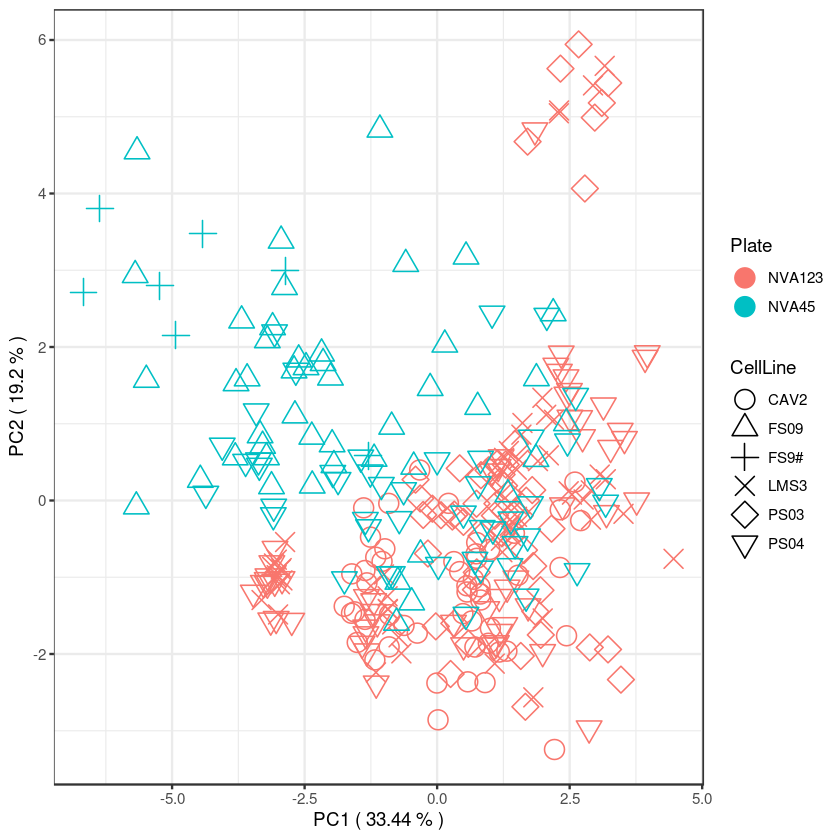

In [708]:
ggplot(PCA_data, aes(PC1,PC2, colour= Plate, shape = CellLine)) +
  geom_point(aes(shape=CellLine), size=5) +
  scale_shape_manual(values=1:nlevels(CellLine))+
  xlab(paste("PC1", "(",round(PCA_TOT$eig[1,2], 2), "% )"))+
  ylab(paste("PC2", "(",round(PCA_TOT$eig[2,2], 2), "% )"))+
  #geom_text_repel(aes(label=colnames(TABLE)))+
  theme_bw()

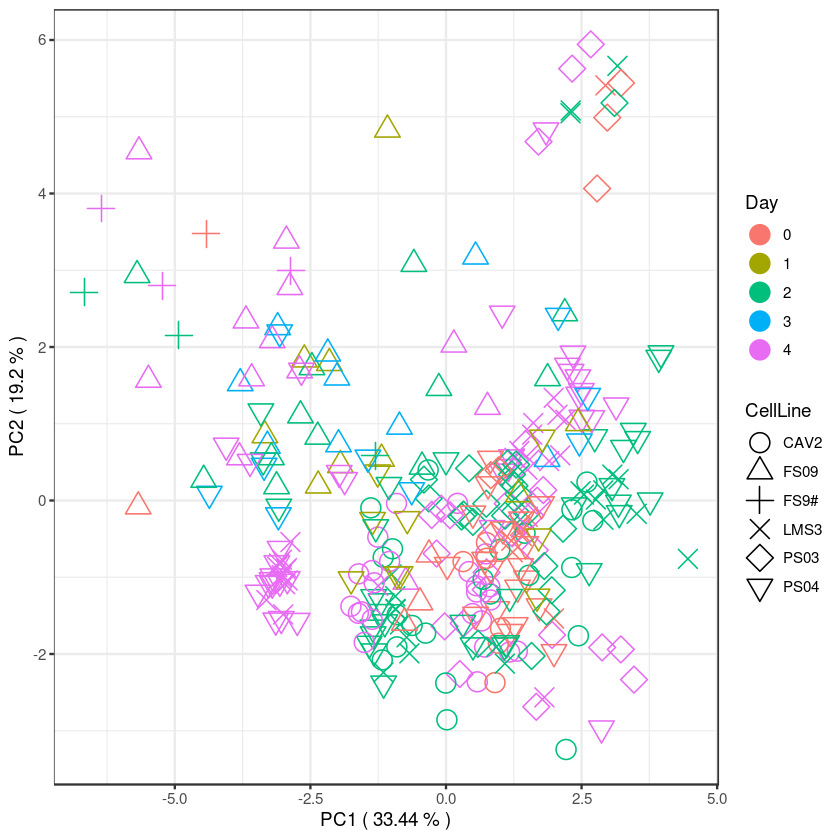

In [709]:
ggplot(PCA_data, aes(PC1,PC2, colour= Day, shape = CellLine)) +
  geom_point(aes(shape=CellLine), size=5) +
  scale_shape_manual(values=1:nlevels(CellLine))+
  xlab(paste("PC1", "(",round(PCA_TOT$eig[1,2], 2), "% )"))+
  ylab(paste("PC2", "(",round(PCA_TOT$eig[2,2], 2), "% )"))+
  #geom_text_repel(aes(label=colnames(TABLE)))+
  theme_bw()

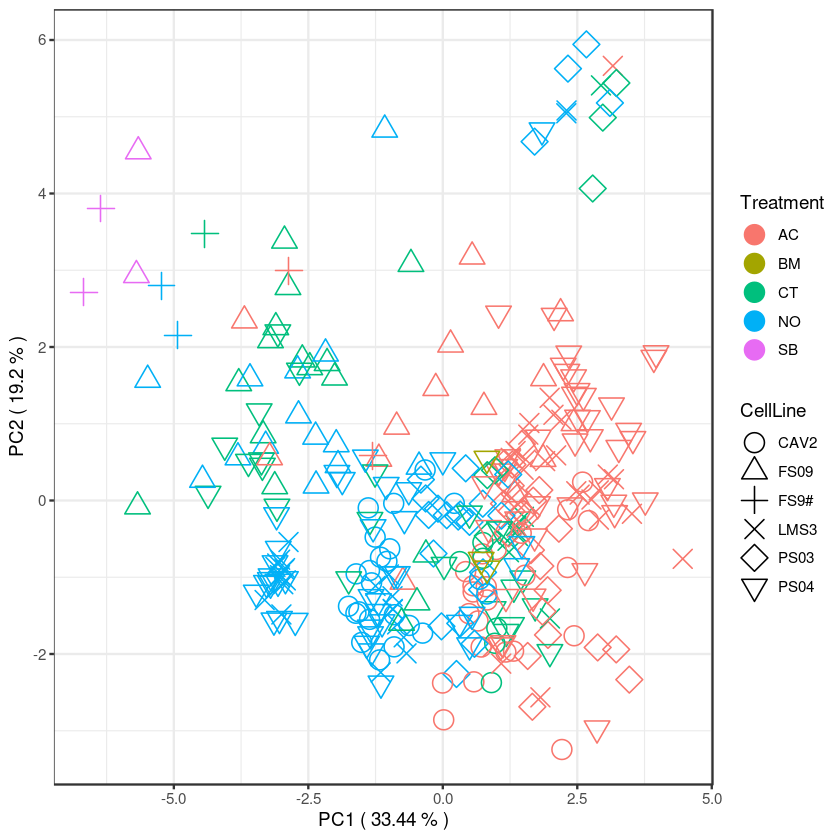

In [710]:
ggplot(PCA_data, aes(PC1,PC2, colour= Treatment, shape = CellLine)) +
  geom_point(aes(shape=CellLine), size=5) +
  scale_shape_manual(values=1:nlevels(CellLine))+
  xlab(paste("PC1", "(",round(PCA_TOT$eig[1,2], 2), "% )"))+
  ylab(paste("PC2", "(",round(PCA_TOT$eig[2,2], 2), "% )"))+
  #geom_text_repel(aes(label=colnames(TABLE)))+
  theme_bw()

The merging of NVA123 and NVA45 is quite good - the PCA shows clearly that Activin and Nodal are doing different things and the trend seems to be conserved. SB43 is also quite on the right axis which makes sense. Therefore, the analyiss will be conducted on NVA123 and NVA45, for the generation of PCA of individual cell lines and DEGs. Some common DEGs between the 5 plates might be compared together so below I am geenrating 3 files: NVA123, NVA45, and NVA12345

In [711]:
biomark_NVA1_EMT_filtered <- biomark_NVA1_EMT %>% filter(Name %in% biomark_NVA1_norm_gene$Name)
biomark_NVA1_TGF_filtered <- biomark_NVA1_TGF %>% filter(Name %in% biomark_NVA1_norm_gene$Name)
biomark_NVA1_EMT_filtered <- biomark_NVA1_EMT_filtered %>% filter(Name %in% biomark_NVA1_TGF_filtered$Name)

dim(biomark_NVA1_EMT)
dim(biomark_NVA1_EMT_filtered)
head(biomark_NVA1_EMT_filtered)
dim(biomark_NVA1_TGF)
dim(biomark_NVA1_TGF_filtered)
head(biomark_NVA1_TGF_filtered)
sum(biomark_NVA1_TGF_filtered$Name == biomark_NVA1_EMT_filtered$Name)


biomark_NVA2_EMT_filtered <- biomark_NVA2_EMT %>% filter(Name %in% biomark_NVA2_norm_gene$Name)
biomark_NVA2_TGF_filtered <- biomark_NVA2_TGF %>% filter(Name %in% biomark_NVA2_norm_gene$Name)
biomark_NVA2_EMT_filtered <- biomark_NVA2_EMT_filtered %>% filter(Name %in% biomark_NVA2_TGF_filtered$Name)

dim(biomark_NVA2_EMT)
dim(biomark_NVA2_EMT_filtered)
head(biomark_NVA2_EMT_filtered)
dim(biomark_NVA2_TGF)
dim(biomark_NVA2_TGF_filtered)
head(biomark_NVA2_TGF_filtered)
sum(biomark_NVA2_TGF_filtered$Name == biomark_NVA2_EMT_filtered$Name)


#biomark_NVA1_EMT_filtered <- biomark_NVA1_EMT_filtered[,-c(which(colnames(biomark_NVA1_norm_gene[,2:ncol(biomark_NVA1_norm_gene)])))]

[1] 96 87

[1] 85 87

,Plate,Name,Ahnak,Akt1,Bmp1,Bmp7,Cald1,Camk2N1,Cav2,Cdh1,⋯,Tspan13,Twist1,Vcan,Vim,Vps13A,Wnt11,Wnt5A,Wnt5B,Zeb1,Zeb2
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,NVA1_EMT,LMS3AC025D2A,-5.694603,-2.768944,-4.129917,-3.485458,-2.966433,-4.113699,-8.283455,-5.751065,⋯,-1.370264,-7.021128,-1.421987,0.31800487,-3.927741,-5.198931,-4.183413,-6.615921,-4.233357,-4.104752
2,NVA1_EMT,LMS3AC025D2B,-5.803653,-3.227547,-4.478319,-3.869003,-3.225024,-4.484186,-8.478946,-6.108581,⋯,-1.649267,-7.194782,-1.710336,0.19280242,-4.114955,-5.284418,-4.401338,-6.743769,-4.253575,-4.097579
3,NVA1_EMT,LMS3AC025D2C,-6.275178,-3.385477,-4.605045,-4.089168,-3.411936,-4.886756,-8.811352,-6.296486,⋯,-1.777214,-7.262216,-2.035133,0.03866094,-4.410062,-5.253069,-4.603955,-6.707081,-4.541058,-4.485405
4,NVA1_EMT,LMS3AC025D4A,-6.453225,-3.030392,-4.271172,-4.718965,-2.708883,-4.284388,-9.403684,-6.725912,⋯,-1.993391,-5.902333,-1.840605,0.17092567,-4.603107,-7.922606,-4.781595,-7.064323,-4.076120,-3.795271
5,NVA1_EMT,LMS3AC025D4B,-6.421522,-3.063389,-4.495438,-5.064475,-3.002184,-4.229858,-9.365832,-6.959421,⋯,-2.124207,-6.026787,-2.227660,-0.07431135,-4.855874,-7.816765,-4.873737,-7.105464,-3.943171,-3.702910
6,NVA1_EMT,LMS3AC025D4C,-6.050440,-2.875115,-3.980189,-4.639676,-2.359135,-3.661438,-8.821976,-6.790863,⋯,-1.910410,-5.896057,-1.743872,-0.03196923,-4.505916,-7.928473,-4.777316,-7.146101,-3.989634,-3.664431


[1] 96 86

[1] 85 86

,Plate,Name,Acta2,Acvr1,Acvrl1,Agt,Aipl1,Ar,Atf3,Atf4,⋯,Sox4,Sp1,Srebf2,Tgfb2,Tgfbr2,Thbs1,Tnfsf10,Txnip,Vegfa,Wfs1
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,NVA1_TGF,LMS3AC025D2A,-6.859626,-4.816927,-8.997225,-11.42025,-11.72724,-8.847420,-9.631519,-2.643435,⋯,-19.70988,-1.838674,-4.819786,-6.225172,-7.262792,-4.166829,-15,-1.936357,-1.576813,-4.813013
2,NVA1_TGF,LMS3AC025D2B,-6.671871,-4.732301,-9.035226,-12.06158,-11.40952,-9.225957,-9.707335,-3.295010,⋯,-20.55826,-1.822166,-5.551465,-6.441209,-7.417301,-3.826078,-15,-1.567968,-1.422797,-4.582913
3,NVA1_TGF,LMS3AC025D2C,-6.677825,-5.088850,-9.240318,-12.41896,-12.48242,-9.209913,-9.823494,-3.811758,⋯,-15.69356,-1.591397,-5.807017,-6.766989,-7.780562,-3.758210,-15,-1.755257,-1.142578,-4.387745
4,NVA1_TGF,LMS3AC025D4A,-4.144531,-4.263530,-9.822584,-11.75926,-11.95422,-8.995522,-10.063957,-3.433211,⋯,-17.06822,-1.981301,-5.831899,-5.918210,-7.885951,-4.587669,-15,-1.892733,-1.354670,-4.620768
5,NVA1_TGF,LMS3AC025D4B,-4.558746,-4.708766,-9.492391,-11.09159,-11.94484,-9.692316,-9.800251,-2.806357,⋯,-16.42556,-2.568197,-4.813274,-5.749915,-7.414587,-5.022381,-15,-2.534367,-1.805104,-5.152509
6,NVA1_TGF,LMS3AC025D4C,-4.315447,-4.280420,-9.147494,-11.33040,-11.20614,-9.052293,-9.454242,-2.523014,⋯,-16.20895,-2.281554,-5.157844,-5.845682,-7.684098,-4.878541,-15,-2.266565,-1.364993,-5.123107


[1] 85

[1] 78 87

[1] 73 87

,Plate,Name,Ahnak,Akt1,Bmp1,Bmp7,Cald1,Camk2N1,Cav2,Cdh1,⋯,Tspan13,Twist1,Vcan,Vim,Vps13A,Wnt11,Wnt5A,Wnt5B,Zeb1,Zeb2
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,NVA2_EMT,CAV2AC025D2A,-5.424899,-1.6021242,-2.655782,-1.844770,-0.8170911,-4.326511,-7.070224,-5.705692,⋯,-0.9323861,-6.836259,0.0928447,1.5548659,-3.612204,-4.986231,-3.211583,-6.281965,-5.465426,-4.531690
2,NVA2_EMT,CAV2AC025D2B,-4.974827,-1.6880068,-3.137319,-2.797585,-1.3023168,-4.767461,-6.776628,-5.799107,⋯,-1.4105461,-6.620521,-0.4078476,0.9994828,-3.541859,-6.128435,-3.247017,-6.288096,-4.705106,-4.094247
3,NVA2_EMT,CAV2AC025D2C,-4.738343,-2.5400961,-3.473805,-3.317664,-1.5562014,-5.218051,-7.105356,-5.737169,⋯,-1.5560943,-6.420535,-0.3750244,0.8357055,-3.398556,-5.809596,-3.312497,-6.584521,-4.760035,-3.974118
4,NVA2_EMT,CAV2AC025D4A,-2.754552,-0.5424380,-1.316830,-2.363181,1.4466802,-2.475285,-5.427097,-7.628750,⋯,-0.6461326,-4.552553,0.2934478,2.5384081,-3.598721,-4.078705,-1.916834,-5.471394,-4.992153,-4.001746
5,NVA2_EMT,CAV2AC025D4B,-2.301660,-0.8063702,-1.708894,-3.347666,0.8521639,-3.560025,-5.246040,-7.687923,⋯,-1.6486664,-4.906366,-0.3515939,1.7685209,-4.193390,-4.498024,-2.575043,-5.635671,-5.249787,-4.090763
6,NVA2_EMT,CAV2AC025D4C,-2.576332,-1.2153357,-2.423634,-3.868255,0.3659698,-3.581813,-6.174507,-7.910444,⋯,-1.5646681,-4.996843,-0.5332288,1.8534743,-4.459786,-4.233609,-3.371452,-5.943382,-4.976114,-3.718951


[1] 74 86

[1] 73 86

,Plate,Name,Acta2,Acvr1,Acvrl1,Agt,Aipl1,Ar,Atf3,Atf4,⋯,Sox4,Sp1,Srebf2,Tgfb2,Tgfbr2,Thbs1,Tnfsf10,Txnip,Vegfa,Wfs1
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,NVA2_TGF,CAV2AC025D2A,-5.6254543,-4.464067,-7.909332,-9.934951,-11.23883,-7.968267,-9.010326,-3.594008,⋯,-15.00000,-1.215275,-6.804211,-5.632932,-6.435658,-3.688717,-15,-0.6772616,-2.470586,-4.566022
2,NVA2_TGF,CAV2AC025D2B,-6.4000444,-5.003057,-7.961440,-9.569158,-11.81288,-8.167177,-9.012460,-3.053908,⋯,-14.31684,-1.818085,-5.513731,-5.720679,-5.876602,-3.946459,-15,-1.4242311,-2.596446,-5.020951
3,NVA2_TGF,CAV2AC025D2C,-5.9422214,-4.873161,-7.510396,-9.445322,-11.70407,-7.981434,-8.820736,-3.556969,⋯,-13.60304,-1.414834,-5.933383,-5.601939,-5.846215,-3.859323,-15,-0.8409406,-2.356830,-4.585226
4,NVA2_TGF,CAV2AC025D4A,1.6193861,-4.100147,-10.552462,-12.937137,-11.15963,-8.512644,-8.067529,-3.581877,⋯,-15.00000,-1.636508,-6.248265,-5.217934,-5.430044,1.449333,-15,-2.1658699,-2.616981,-4.483962
5,NVA2_TGF,CAV2AC025D4B,1.1952537,-4.255456,-10.639058,-9.491864,-10.49052,-8.530084,-8.057825,-2.752726,⋯,-15.61794,-2.207282,-4.095959,-4.809457,-4.169508,1.380870,-15,-2.9485875,-3.453066,-4.827501
6,NVA2_TGF,CAV2AC025D4C,0.9320767,-4.204932,-10.646463,-11.423384,-10.92012,-8.367942,-7.538649,-2.641044,⋯,-15.00000,-1.775540,-4.751014,-5.232988,-5.118093,1.163560,-15,-3.1250772,-3.267873,-4.817054


[1] 73

In [712]:
intersect(colnames(biomark_NVA1_EMT_filtered[,3:ncol(biomark_NVA1_EMT_filtered)])
     , colnames(biomark_NVA1_norm_gene[,3:ncol(biomark_NVA1_norm_gene)]))
intersect(colnames(biomark_NVA1_TGF_filtered[,3:ncol(biomark_NVA1_TGF_filtered)])
     , colnames(biomark_NVA1_norm_gene[,3:ncol(biomark_NVA1_norm_gene)]))        
intersect(colnames(biomark_NVA2_EMT_filtered[,3:ncol(biomark_NVA2_EMT_filtered)])
     , colnames(biomark_NVA2_norm_gene[,3:ncol(biomark_NVA2_norm_gene)]))        
intersect(colnames(biomark_NVA2_TGF_filtered[,3:ncol(biomark_NVA2_TGF_filtered)])
     , colnames(biomark_NVA2_norm_gene[,3:ncol(biomark_NVA2_norm_gene)]))        

character(0)

character(0)

[1] "Krt14" "Krt19"

[1] "Runx1"

In [713]:
biomark_EMT12 <- rbind.data.frame(biomark_NVA1_EMT_filtered, biomark_NVA2_EMT_filtered)
biomark_TGF12 <- rbind.data.frame(biomark_NVA1_TGF_filtered, biomark_NVA2_TGF_filtered)

NVAET <- cbind.data.frame(biomark_EMT12, biomark_TGF12[,-c(1,2)])
dim(NVAET)
dim(biomark_clean123)
colnames(NVAET)


NVA123ET <- left_join(biomark_clean123[,-1], NVAET[,-1] #careful no more plate annotations here. 
                      %>% select(-one_of(c("Ctnnb1", "Fn1", "Mmp2", "Notch1", "Ptk2", "Serpine1", "Snai1", "Tgfb2")))
                      , by = "Name", copy = TRUE)


NVA123ET <- cbind.data.frame(NVA123ET, biomark_clean123$Plate)
names(NVA123ET)[ncol(NVA123ET)] <- "Plate"

dim(NVA123ET)
head(NVA123ET)
head(NVAET)
head(biomark_clean123)
colnames(NVA123ET)

[1] 158 171

[1] 217  22

[1] "Plate"    "Name"     "Ahnak"    "Akt1"     "Bmp1"     "Bmp7"    
  [7] "Cald1"    "Camk2N1"  "Cav2"     "Cdh1"     "Cdh2"     "Col1A2"  
 [13] "Col3A1"   "Col5A2"   "Ctnnb1"   "Desi1"    "Dsc2"     "Dsp"     
 [19] "Egfr"     "Erbb3"    "Esr1"     "F11R"     "Fgfbp1"   "Fn1"     
 [25] "Foxc2"    "Fzd7"     "Gemin2"   "Gng11"    "Gsc"      "Gsk3B"   
 [31] "HGDC"     "Igfbp4"   "Il1Rn"    "Ilk"      "Itga5"    "Itgav"   
 [37] "Itgb1"    "Jag1"     "Krt14"    "Krt19"    "Krt7"     "Map1B"   
 [43] "Mitf"     "Mmp2"     "Mmp3"     "Mmp9"     "Msn"      "Mst1R"   
 [49] "Nodal"    "Notch1"   "Nudt13"   "Ocln"     "Pdgfrb"   "Plek2"   
 [55] "Ptk2"     "Ptp4A1"   "Rac1"     "Rgs2"     "Serpine1" "Smad2"   
 [61] "Snai1"    "Snai2"    "Snai3"    "Sox10"    "Sparc"    "Spp1"    
 [67] "Stat3"    "Steap1"   "Tcf3"     "Tcf4"     "Tfpi2"    "Tgfb1"   
 [73] "Tgfb2"    "Tgfb3"    "Timp1"    "Tmeff1"   "Tmem132A" "Tspan13" 
 [79] "Twist1"   "Vcan"     "Vim"      "Vps13A"   "Wnt11"    "Wnt5A"   
 [85] "Wnt5B"    "Zeb1"     "Zeb2"     "Acta2"    "Acvr1"    "Acvrl1"  
 [91] "Agt"      "Aipl1"    "Ar"       "Atf3"     "Atf4"     "Bach1"   
 [97] "Bcl2l1"   "Bdnf"     "Bhlhe40"  "Brd2"     "Cdc6"     "Cdkn1b"  
[103] "Cebpb"    "Creb1"    "Crebbp"   "Cryab"    "Ctnnb1"   "Dnaja1"  
[109] "E2f4"     "Emp1"     "Eng"      "Ep300"    "Ephb2"    "Fn1"     
[115] "Fos"      "Furin"    "Gadd45b"  "Gli2"     "Gtf2i"    "Herpud1" 
[121] "Hes1"     "Hey1"     "Hmox1"    "Id1"      "Id2"      "Id3"     
[127] "Ifrd1"    "Il10"     "Klf10"    "Map3k7"   "Mapk14"   "Mapk8"   
[133] "Mbd1"     "Mmp2"     "Msx2"     "Myc"      "Myod1"    "Nfib"    
[139] "Nfkbia"   "Notch1"   "Pdgfa"    "Plg"      "Ppara"    "Ptgs2"   
[145] "Pthlh"    "Ptk2"     "Ptk2b"    "Rad21"    "Rara"     "Rbl1"    
[151] "Rhoa"     "Rhob"     "Runx1"    "S100a8"   "Serpine1" "Shh"     
[157] "Smad1"    "Smad3"    "Smad5"    "Smad6"    "Snai1"    "Sox4"    
[163] "Sp1"      "Srebf2"   "Tgfb2"    "Tgfbr2"   "Thbs1"    "Tnfsf10" 
[169] "Txnip"    "Vegfa"    "Wfs1"

[1] 217 183

,Name,Alb,Fgf5,Gata1,Gata2,Gata6,Gdf3,Gfap,Hand1,Hnf4a,⋯,Sp1,Srebf2,Tgfb2.1,Tgfbr2,Thbs1,Tnfsf10,Txnip,Vegfa,Wfs1,Plate
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,LMS3AC025D2A,-13.87625,-1.667977,-12.79158,-11.137755,-5.915775,-8.722328,-3.388918,-14.86566,-14.74904,⋯,-1.838674,-4.819786,-6.225172,-7.262792,-4.166829,-15,-1.936357,-1.576813,-4.813013,NVA1
2,LMS3AC025D2B,-14.30774,-1.768353,-12.92359,-11.154593,-5.971406,-8.203500,-3.324410,-15.33538,-15.54182,⋯,-1.822166,-5.551465,-6.441209,-7.417301,-3.826078,-15,-1.567968,-1.422797,-4.582913,NVA1
3,LMS3AC025D2C,-14.77774,-1.599629,-13.00271,-11.957169,-5.816322,-8.034493,-2.844446,-14.66951,-13.87392,⋯,-1.591397,-5.807017,-6.766989,-7.780562,-3.758210,-15,-1.755257,-1.142578,-4.387745,NVA1
4,LMS3AC025D4A,-12.98461,-3.275699,-13.45556,-9.446853,-5.688003,-9.770710,-3.452660,-11.66461,-10.25608,⋯,-1.981301,-5.831899,-5.918210,-7.885951,-4.587669,-15,-1.892733,-1.354670,-4.620768,NVA1
5,LMS3AC025D4B,-13.64117,-4.521821,-15.76153,-9.217460,-7.628088,-10.149894,-4.322119,-13.39360,-11.81537,⋯,-2.568197,-4.813274,-5.749915,-7.414587,-5.022381,-15,-2.534367,-1.805104,-5.152509,NVA1
6,LMS3AC025D4C,-13.97276,-4.552419,-14.24961,-10.033617,-7.696850,-10.099433,-4.504905,-12.11784,-11.38917,⋯,-2.281554,-5.157844,-5.845682,-7.684098,-4.878541,-15,-2.266565,-1.364993,-5.123107,NVA1


,Plate,Name,Ahnak,Akt1,Bmp1,Bmp7,Cald1,Camk2N1,Cav2,Cdh1,⋯,Sox4,Sp1,Srebf2,Tgfb2,Tgfbr2,Thbs1,Tnfsf10,Txnip,Vegfa,Wfs1
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,NVA1_EMT,LMS3AC025D2A,-5.694603,-2.768944,-4.129917,-3.485458,-2.966433,-4.113699,-8.283455,-5.751065,⋯,-19.70988,-1.838674,-4.819786,-6.225172,-7.262792,-4.166829,-15,-1.936357,-1.576813,-4.813013
2,NVA1_EMT,LMS3AC025D2B,-5.803653,-3.227547,-4.478319,-3.869003,-3.225024,-4.484186,-8.478946,-6.108581,⋯,-20.55826,-1.822166,-5.551465,-6.441209,-7.417301,-3.826078,-15,-1.567968,-1.422797,-4.582913
3,NVA1_EMT,LMS3AC025D2C,-6.275178,-3.385477,-4.605045,-4.089168,-3.411936,-4.886756,-8.811352,-6.296486,⋯,-15.69356,-1.591397,-5.807017,-6.766989,-7.780562,-3.758210,-15,-1.755257,-1.142578,-4.387745
4,NVA1_EMT,LMS3AC025D4A,-6.453225,-3.030392,-4.271172,-4.718965,-2.708883,-4.284388,-9.403684,-6.725912,⋯,-17.06822,-1.981301,-5.831899,-5.918210,-7.885951,-4.587669,-15,-1.892733,-1.354670,-4.620768
5,NVA1_EMT,LMS3AC025D4B,-6.421522,-3.063389,-4.495438,-5.064475,-3.002184,-4.229858,-9.365832,-6.959421,⋯,-16.42556,-2.568197,-4.813274,-5.749915,-7.414587,-5.022381,-15,-2.534367,-1.805104,-5.152509
6,NVA1_EMT,LMS3AC025D4C,-6.050440,-2.875115,-3.980189,-4.639676,-2.359135,-3.661438,-8.821976,-6.790863,⋯,-16.20895,-2.281554,-5.157844,-5.845682,-7.684098,-4.878541,-15,-2.266565,-1.364993,-5.123107


,Plate,Name,Alb,Fgf5,Gata1,Gata2,Gata6,Gdf3,Gfap,Hand1,⋯,Nanog,Olig2,Otx2,Pou5f1,Sox17,Sox2,Sox7,T,Tat,Zfp42
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,NVA1,LMS3AC025D2A,-13.87625,-1.667977,-12.79158,-11.137755,-5.915775,-8.722328,-3.388918,-14.86566,⋯,-1.523390,-9.344434,-3.218549,0.8913783,-1.331135,-15.00000,-12.23849,-2.498316,-15.00000,-13.87509
2,NVA1,LMS3AC025D2B,-14.30774,-1.768353,-12.92359,-11.154593,-5.971406,-8.203500,-3.324410,-15.33538,⋯,-1.491077,-10.158595,-3.207072,1.2230291,-1.687327,-15.00000,-12.54289,-2.390660,-18.00453,-13.78454
3,NVA1,LMS3AC025D2C,-14.77774,-1.599629,-13.00271,-11.957169,-5.816322,-8.034493,-2.844446,-14.66951,⋯,-1.658402,-10.580202,-3.169825,0.7228994,-1.883571,-21.80259,-12.38875,-2.035735,-15.00000,-13.75803
4,NVA1,LMS3AC025D4A,-12.98461,-3.275699,-13.45556,-9.446853,-5.688003,-9.770710,-3.452660,-11.66461,⋯,-1.049073,-11.133586,-3.027180,1.0065121,-1.357619,-15.00000,-11.02648,-6.724909,-15.00000,-13.86808
5,NVA1,LMS3AC025D4B,-13.64117,-4.521821,-15.76153,-9.217460,-7.628088,-10.149894,-4.322119,-13.39360,⋯,-1.965148,-10.396095,-3.508844,0.7765034,-1.550885,-15.00000,-12.51317,-6.027038,-15.00000,-17.86430
6,NVA1,LMS3AC025D4C,-13.97276,-4.552419,-14.24961,-10.033617,-7.696850,-10.099433,-4.504905,-12.11784,⋯,-1.874500,-10.518033,-3.505989,0.6016185,-1.564005,-15.00000,-11.97591,-6.182131,-16.83572,-14.40239


[1] "Name"       "Alb"        "Fgf5"       "Gata1"      "Gata2"     
  [6] "Gata6"      "Gdf3"       "Gfap"       "Hand1"      "Hnf4a"     
 [11] "Mixl1"      "Nanog"      "Olig2"      "Otx2"       "Pou5f1"    
 [16] "Sox17"      "Sox2"       "Sox7"       "T"          "Tat"       
 [21] "Zfp42"      "Ahnak"      "Akt1"       "Bmp1"       "Bmp7"      
 [26] "Cald1"      "Camk2N1"    "Cav2"       "Cdh1"       "Cdh2"      
 [31] "Col1A2"     "Col3A1"     "Col5A2"     "Desi1"      "Dsc2"      
 [36] "Dsp"        "Egfr"       "Erbb3"      "Esr1"       "F11R"      
 [41] "Fgfbp1"     "Foxc2"      "Fzd7"       "Gemin2"     "Gng11"     
 [46] "Gsc"        "Gsk3B"      "HGDC"       "Igfbp4"     "Il1Rn"     
 [51] "Ilk"        "Itga5"      "Itgav"      "Itgb1"      "Jag1"      
 [56] "Krt14"      "Krt19"      "Krt7"       "Map1B"      "Mitf"      
 [61] "Mmp3"       "Mmp9"       "Msn"        "Mst1R"      "Nodal"     
 [66] "Nudt13"     "Ocln"       "Pdgfrb"     "Plek2"      "Ptp4A1"    
 [71] "Rac1"       "Rgs2"       "Smad2"      "Snai2"      "Snai3"     
 [76] "Sox10"      "Sparc"      "Spp1"       "Stat3"      "Steap1"    
 [81] "Tcf3"       "Tcf4"       "Tfpi2"      "Tgfb1"      "Tgfb3"     
 [86] "Timp1"      "Tmeff1"     "Tmem132A"   "Tspan13"    "Twist1"    
 [91] "Vcan"       "Vim"        "Vps13A"     "Wnt11"      "Wnt5A"     
 [96] "Wnt5B"      "Zeb1"       "Zeb2"       "Acta2"      "Acvr1"     
[101] "Acvrl1"     "Agt"        "Aipl1"      "Ar"         "Atf3"      
[106] "Atf4"       "Bach1"      "Bcl2l1"     "Bdnf"       "Bhlhe40"   
[111] "Brd2"       "Cdc6"       "Cdkn1b"     "Cebpb"      "Creb1"     
[116] "Crebbp"     "Cryab"      "Ctnnb1.1"   "Dnaja1"     "E2f4"      
[121] "Emp1"       "Eng"        "Ep300"      "Ephb2"      "Fn1.1"     
[126] "Fos"        "Furin"      "Gadd45b"    "Gli2"       "Gtf2i"     
[131] "Herpud1"    "Hes1"       "Hey1"       "Hmox1"      "Id1"       
[136] "Id2"        "Id3"        "Ifrd1"      "Il10"       "Klf10"     
[141] "Map3k7"     "Mapk14"     "Mapk8"      "Mbd1"       "Mmp2.1"    
[146] "Msx2"       "Myc"        "Myod1"      "Nfib"       "Nfkbia"    
[151] "Notch1.1"   "Pdgfa"      "Plg"        "Ppara"      "Ptgs2"     
[156] "Pthlh"      "Ptk2.1"     "Ptk2b"      "Rad21"      "Rara"      
[161] "Rbl1"       "Rhoa"       "Rhob"       "Runx1"      "S100a8"    
[166] "Serpine1.1" "Shh"        "Smad1"      "Smad3"      "Smad5"     
[171] "Smad6"      "Snai1.1"    "Sox4"       "Sp1"        "Srebf2"    
[176] "Tgfb2.1"    "Tgfbr2"     "Thbs1"      "Tnfsf10"    "Txnip"     
[181] "Vegfa"      "Wfs1"       "Plate"

Bind together NVA123ET and NVA45
Can't normalise as the common samples do not share the new genes. 
I guess I could try if I assume the replicates are the similar - but very risky. 

In [714]:
NVA123ET45 <- rbind.fill(NVA123ET, NVA45)
head(NVA123ET45)
tail(NVA123ET45)
dim(NVA123ET45)
intersect(colnames(NVA123ET), colnames(NVA45))
length(intersect(colnames(NVA123ET), colnames(NVA45)))

,Name,Alb,Fgf5,Gata1,Gata2,Gata6,Gdf3,Gfap,Hand1,Hnf4a,⋯,Tgfb2,Tgfbi,Tgfbr1,Thy1,Wnt3,Wnt3a,Wnt5a,Zic1,Ctnnb1,FoxD3
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,LMS3AC025D2A,-13.87625,-1.667977,-12.79158,-11.137755,-5.915775,-8.722328,-3.388918,-14.86566,-14.74904,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2,LMS3AC025D2B,-14.30774,-1.768353,-12.92359,-11.154593,-5.971406,-8.203500,-3.324410,-15.33538,-15.54182,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
3,LMS3AC025D2C,-14.77774,-1.599629,-13.00271,-11.957169,-5.816322,-8.034493,-2.844446,-14.66951,-13.87392,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
4,LMS3AC025D4A,-12.98461,-3.275699,-13.45556,-9.446853,-5.688003,-9.770710,-3.452660,-11.66461,-10.25608,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
5,LMS3AC025D4B,-13.64117,-4.521821,-15.76153,-9.217460,-7.628088,-10.149894,-4.322119,-13.39360,-11.81537,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
6,LMS3AC025D4C,-13.97276,-4.552419,-14.24961,-10.033617,-7.696850,-10.099433,-4.504905,-12.11784,-11.38917,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


,Name,Alb,Fgf5,Gata1,Gata2,Gata6,Gdf3,Gfap,Hand1,Hnf4a,⋯,Tgfb2,Tgfbi,Tgfbr1,Thy1,Wnt3,Wnt3a,Wnt5a,Zic1,Ctnnb1,FoxD3
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
317,FS9#AC100D4D,NA,-4.031268,-9.576851,-8.288757,-10.093432,NA,-11.23078,-13.247235,-11.89348,⋯,-8.140104,-10.228512,-6.479191,-8.456498,-7.984407,-11.85407,-17.18165,-7.985898,-1.917002,-8.313646
318,FS9#NO100D4D,NA,-7.969563,-11.161560,-8.456854,-12.430221,NA,-14.22973,-15.000000,-14.43614,⋯,-9.950618,-11.049803,-5.170688,-10.461387,-8.569619,-12.36662,-15.00000,-14.572010,-2.072334,-9.071301
319,FS9#SB001D4D,NA,-15.345479,-9.261118,-10.412454,-15.595933,NA,-11.00603,-15.000000,-10.42111,⋯,-9.422837,-10.722350,-4.761219,-12.292868,-8.968989,-11.33268,-16.90501,-10.537554,-2.346423,-10.317525
320,PS04CT000D0G,NA,-8.798051,-14.257184,-14.509975,-14.965889,NA,-15.00000,-14.148219,-14.83136,⋯,-9.815284,-6.811415,-7.634236,-6.633018,-8.063385,-15.00000,-15.00000,-17.596390,-2.674072,-10.377969
321,PS04CT000D2H,NA,-3.513628,-15.000000,-13.816025,-7.556640,NA,-15.00000,-9.818688,-15.00000,⋯,-9.369120,-7.621454,-7.420938,-10.668413,-4.555622,-10.66429,-16.91697,-11.365289,-2.359194,-8.832077
322,PS04CT000D2I,NA,-3.143439,-12.955661,-13.174677,-7.157258,NA,-15.29235,-10.190094,-15.00000,⋯,-10.162392,-8.018060,-7.338612,-11.180782,-5.107417,-11.77089,-15.00000,-11.500380,-2.266776,-8.395178


[1] 322 240

[1] "Name"   "Fgf5"   "Gata1"  "Gata2"  "Gata6"  "Gfap"   "Hand1"  "Hnf4a" 
 [9] "Mixl1"  "Nanog"  "Olig2"  "Otx2"   "Pou5f1" "Sox17"  "Sox2"   "Sox7"  
[17] "T"      "Zfp42"  "Cdh1"   "Cdh2"   "Dsp"    "Fzd7"   "Gsc"    "Nodal" 
[25] "Pdgfrb" "Rgs2"   "Smad2"  "Spp1"   "Tcf4"   "Tfpi2"  "Tgfb3"  "Twist1"
[33] "Vim"    "Wnt11"  "Acvr1"  "Smad1"  "Smad5"  "Tgfbr2" "Plate"

[1] 39

In [715]:
write.csv(biomark_clean23, file = "NVA23.csv")
write.csv(biomark_clean123, file = "NVA123.csv")
write.csv(NVA123ET, file = "NVA123ET.csv")
write.csv(biomark_clean45, file = "NVA45.csv")
write.csv(biomark_clean12345, file = "NVA12345.csv")
write.csv(NVA123ET45, file = "NVA123ET45.csv")

In [716]:
sessionInfo()

R version 4.0.2 (2020-06-22)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS:   /mnt/processing/R/4.0.2/lib64/R/lib/libRblas.so
LAPACK: /mnt/processing/R/4.0.2/lib64/R/lib/libRlapack.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] parallel  stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] repr_1.1.3          FactoMineR_2.4      forcats_0.5.1      
 [4] stringr_1.4.0       purrr_0.3.4         tidyr_1.1.2        
 [7] tibble_3.0.5        tidyverse_1.3.0     readr_1.4.0        
[10] HTqPCR_1.44.0       RColorBrewer_1.1-2  Biobase_2.50.